## Diesel Truck Data


In [11]:
#python version
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


The data was gathered on diesel truck Inline 6-cylinder, 4-stroke-cycle.  The truck sensors(channels) are measured based on indutry standard.  

There are two industry standard.  One is Society of Automotive Engineers standard SAE J1939 is the vehicle bus recommended practice used for communication and diagnostics among vehicle components. Originating in the car and heavy-duty truck industry in the United States, it is now widely used in other parts of the world.  

The J1587 protocol is exclusively used within heavy duty vehicles, where it is used for data exchange between nodes in a network, driver information or diagnosis. Areas of use are: Vehicle and component information (performance, maintenance, diagnosis).  In this research, the team used both as they are available to capture the system behaviors.  

In this project, we will focus on the enigne system


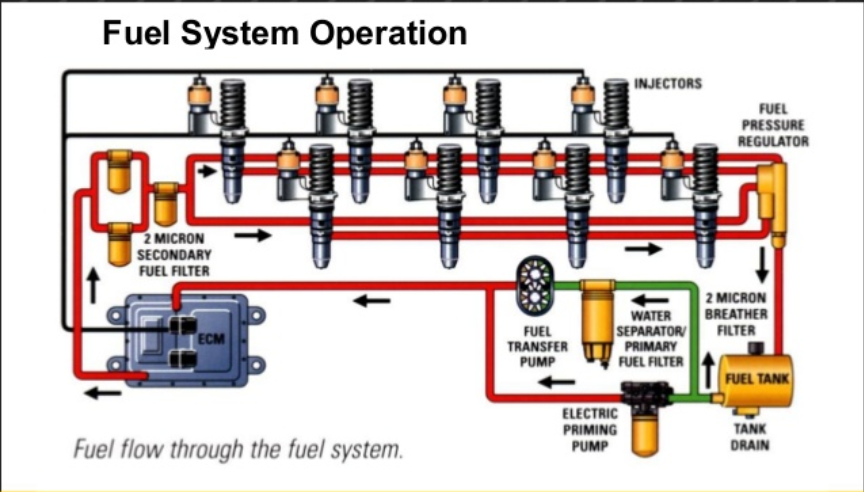

In [12]:
from IPython.display import Image
#Image(filename='LubeSystem.png')
Image(filename='fuelsystem.png')
#The image was taken from https://www.slideshare.net/wilbort/engine-systems-diesel-engine-analyst-full
#https://www.conequip.com/docs/cat_c7_diesel_engine_parts_diagram.pdf

In [20]:
#!pip install pandas pyarrow

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import pyarrow.parquet as pq
import random
random.seed(42)
import numpy as np
np.random.seed(42)

## Methods Description

The workflow involves the following steps:

- **Data Preprocessing**: Handling missing values, feature scaling, and encoding categorical variables if necessary.
- **Feature Selection**: Selecting relevant features for prediction.
- **Model Training**: Training models using the training dataset.
- **Hyperparameter Tuning**: Fine-tuning models to improve performance.
- **Evaluation**: Evaluating model performance on a separate test dataset.

In [14]:

import pandas as pd

# Read data
def read_parquet_file(parquet_file_path):
    """Reads a parquet file and returns a DataFrame."""
    return pd.read_parquet(parquet_file_path)

def read_csv_file(csv_file_path):
    """Reads a CSV file and returns a DataFrame."""
    return pd.read_csv(csv_file_path)

def select_and_clean_channels(df_channel_name):
    """Selects important channels and cleans their names and units."""
    # Make a copy of the filtered DataFrame to avoid SettingWithCopyWarning
    df_selected = df_channel_name[df_channel_name['Select'] == 1].copy()
    
    # Clean channel names by removing the prefix and text in brackets
    df_selected['channel_name'] = df_selected['channel_name'].apply(lambda x: x.split('(')[0][7:])
    
    # Define replacements for measurement units
    replacements = {
        'Degrees Fahrenheit': 'F',
        'Pounds Per Square Inch': 'psi',
        'Gallons': 'gallons',
        'Integer Percentage, Percent Form': '%',
        'Base 10 Real Number': '',
        'Float Percentage, Percent Form': '%',
        'Base 10 Integer Number': '',
        'Revolutions Per Minute (RPM)': 'RPM',
        'gal (U.S.) Per Hour': 'gallons/hr',
        'gallons (U.S.) Per Hour': 'gallons/hr',
        'Miles Per Hour': 'miles/hour',
        'ASCII String': ''
    }
    
    for old_unit, new_unit in replacements.items():
        df_selected['Measurement_Unit'] = df_selected['Measurement_Unit'].str.replace(old_unit, new_unit)
    
    # Set specific measurement units for certain keywords
    specific_keywords_units = {'TrSelGr': '-1,0,..7', 
                               'TransCurGear': '-1,0,..7', 
                               'TranActGearRato': '-1,0,..7', 
                               'TrRgAttai'	: '-1,0,..7',
                               'TransDrivEng' : '0/1', 
                               'TransTorqConvLockupEngaged' : '0/1',}
    for keyword, unit in specific_keywords_units.items():
        df_selected.loc[df_selected['Keyword'] == keyword, 'Measurement_Unit'] = unit
    
    # Reset the index and remove the 'Select' column
    df_selected.reset_index(drop=True, inplace=True)
    df_selected.drop(columns=['Select'], inplace=True)
    
    return df_selected

# Select features 
parquet_file_path = 'myDataset_VIN02731.parquet'
csv_file_path = 'channel_name_with_unit.csv'

df = read_parquet_file(parquet_file_path)
df_channel_name = read_csv_file(csv_file_path)
df_channel_name_selected = select_and_clean_channels(df_channel_name)


#Select the columns from the dataframe
selected_columns = df_channel_name_selected['Keyword'].tolist()

# Display the cleaned and selected channel names DataFrame
df_channel_name_selected



Keyword  \
0                  AccelPedalPos   
1               BarPres_Eng_1587   
2                      BoostPres   
3                 BoostPres_1587   
4                   CoolantLevel   
5                 EngCoolantTemp   
6            EngCoolantTemp_1587   
7                EngDesiredOpSpd   
8                  EngDmdPctTorq   
9                     EngOilPres   
10               EngOilPres_1587   
11              EngPctLdAtCurSpd   
12                    EngPctTorq   
13                     EngRtdPwr   
14                   EngRtdSpeed   
15                      EngSpeed   
16                      FuelRate   
17                    InjCtlPres   
18              InjCtrlPres_1587   
19                      InpSftSp   
20                   InstFuelEco   
21                   IntManfTemp   
22              IntManfTemp_1587   
23                    PctEngLoad   
24                RtdEngPwr_1587   
25              RtdEngSpeed_1587   
26                     TotEngHrs   
27                TotEngHrs_1587   
28              TotIdlHours_1587   
29               TranActGearRato   
30                  TransCurGear   
31                  TransDrivEng   
32                  TransOilTemp   
33  TransOptShaftSpeedTrans_1587   
34    TransTorqConvLockupEngaged   
35                     TrRgAttai   
36                       TrSelGr   
37                   VehSpeedEng   

                                      channel_name Measurement_Unit  
0                      Accelerator Pedal Position                 %  
1                             Barometric Pressure               psi  
2            Boost Pressure from Intake Manifold                psi  
3                                  Boost Pressure               psi  
4                                   Coolant Level                 %  
5                      Engine Coolant Temperature                 F  
6                      Engine Coolant Temperature                 F  
7                Engine s Desired Operating Speed               RPM  
8                  Engine Demand - Percent Torque                 %  
9                             Engine Oil Pressure               psi  
10                            Engine Oil Pressure               psi  
11           Engine Percent Load At Current Speed                 %  
12         Drivers Demand Engine - Percent Torque                 %  
13                             Engine Rated Power        Horsepower  
14                             Engine Rated Speed               RPM  
15                                   Engine Speed               RPM  
16                                      Fuel Rate        gallons/hr  
17                     Injection Control Pressure               psi  
18                     Injection Control Pressure               psi  
19                              Input Shaft Speed               RPM  
20                     Instantaneous Fuel Economy        gallons/hr  
21                    Intake Manifold Temperature                 F  
22                    Intake Manifold Temperature                 F  
23                  Actual Engine- Percent Torque                 %  
24                             Rated Engine Power        Horsepower  
25                             Rated Engine Speed               RPM  
26                             Total Engine Hours             Hours  
27                             Total Engine Hours             Hours  
28                               Total Idle Hours             Hours  
29                 Transmission Actual Gear Ratio          -1,0,..7  
30                      Transmission Current Gear          -1,0,..7  
31                 Transmission Driveline Engaged               0/1  
32                   Transmission Oil Temperature                 F  
33                Transmission Output Shaft Speed               RPM  
34   Transmission Torque Converter Lockup Engaged               0/1  
35                    Transmission Range Attained          -1,0,..7  
36                     Transmi

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1720248 entries, 2016-02-02 16:20:25 to 2020-02-12 22:09:20
Columns: 173 entries, UTC_1Hz to VehSpeedBrakes_1587
dtypes: datetime64[ns](3), float64(151), object(19)
memory usage: 2.2+ GB


The DataFrame contains 1,720,248 entries with a DatetimeIndex ranging from February 2, 2016, to February 12, 2020, has 173 columns including 'UTC_1Hz' to 'VehSpeedBrakes_1587', with data types of datetime (3 columns), float (151 columns), and object (19 columns), and uses about 2.2 GB of memory.

In [6]:
df.describe()

UTC_1Hz  BrakeSwitch  TrOutShaftSp  \
count                        1720248    1718769.0  1.719954e+06   
mean   2017-12-30 22:22:49.282142720          0.0  4.304101e+02   
min              2016-02-02 16:20:25          0.0  0.000000e+00   
25%    2017-03-02 19:21:23.750000128          0.0  0.000000e+00   
50%       2017-12-07 15:26:19.500000          0.0  0.000000e+00   
75%    2018-09-27 19:35:54.249999872          0.0  5.547500e+02   
max              2020-02-12 22:09:20          0.0  3.577250e+03   
std                              NaN          0.0  7.108704e+02   

       AuxHeatModeReq      EngSpeed      FuelRate   IntManfTemp  \
count       1677860.0  1.719872e+06  1.718759e+06  1.717567e+06   
mean             15.0  9.601559e+02  2.191037e+00  8.638504e+01   
min              15.0  0.000000e+00  0.000000e+00  2.300000e+01   
25%              15.0  6.992500e+02  6.868473e-01  7.340000e+01   
50%              15.0  7.033750e+02  9.906452e-01  8.600000e+01   
75%              15.0  1.304125e+03  2.113376e+00  1.004000e+02   
max              15.0  3.827500e+03  2.093563e+01  1.850000e+02   
std               0.0  4.085392e+02  2.952187e+00  1.921017e+01   

       PTOGovernorSetSwtchEng  ASROffRoadSwtchTire  PTOResSwtch_1587  ...  \
count               1718765.0         1.716506e+06         1439382.0  ...   
mean                      0.0         1.168070e-03               0.0  ...   
min                       0.0         0.000000e+00               0.0  ...   
25%                       0.0         0.000000e+00               0.0  ...   
50%                       0.0         0.000000e+00               0.0  ...   
75%                       0.0         0.000000e+00               0.0  ...   
max                       0.0         1.000000e+00               0.0  ...   
std                       0.0         3.415709e-02               0.0  ...   

                           UTC_Fault  Fault_Protocol  FailureModeIdentifier  \
count                             82            82.0              82.000000   
mean   2018-05-10 15:21:11.195122176             0.0               5.512195   
min              2016-02-11 18:11:21             0.0               0.000000   
25%    2017-02-14 14:47:19.750000128             0.0               4.000000   
50%              2018-01-09 16:34:07             0.0               4.000000   
75%    2019-10-31 09:53:20.750000128             0.0               5.000000   
max              2020-02-06 20:17:40             0.0              14.000000   
std                              NaN             0.0               3.374720   

       OccurrenceCount       AltPotV      AltSpeed  EngAltWindingTemp  \
count        82.000000  1.356127e+06  1.355528e+06       1.355698e+06   
mean          1.158537  2.802310e+01  2.339816e+03       9.850385e+01   
min           1.000000  0.000000e+00  0.000000e+00       2.300000e+01   
25%           1.000000  2.805000e+01  1.698000e+03       7.900000e+01   
50%           1.000000  2.805000e+01  1.704000e+03       9.700000e+01   
75%           1.000000  2.820000e+01  3.123000e+03       1.180000e+02   
max           8.000000  3.020000e+01  7.049000e+03       2.570000e+02   
std           1.011898  9.848853e-01  9.401712e+02       2.698268e+01   

       IntManfTemp_1587  InjCtrlPres_1587  VehSpeedBrakes_1587  
count     926462.000000     926750.000000         1.104403e+06  
mean          85.887778       2160.755415         5.328268e+00  
min           23.000000          0.000000         0.000000e+00  
25%           73.000000       1465.794189         0.000000e+00  
50%           87.000000       1735.495850         0.000000e+00  
75%          100.000000       3099.868652         4.501800e+00  
max          185.000000       5418.962402         5.352140e+01  
std           19.326558        881.478526         9.766994e+00  

[8 rows x 154 columns]

#Here there are measured channels 

In [15]:
#Slice Data for 2017 and 2018
#maintennace event happened for the injector was in 2018.  So, we take take from 2017 and 2018
#extract data from 2017 and 2018
df_2017_2018 = df[(df['UTC_1Hz'] > '2017-01-01') & (df['UTC_1Hz'] < '2019-01-01')]

In [8]:
df_2017_2018.sample(5).T

time                 2017-05-30 17:53:21  2017-04-19 18:32:54  \
UTC_1Hz              2017-05-30 17:53:21  2017-04-19 18:32:54   
BrakeSwitch                          0.0                  0.0   
CrankcasePres                       None                 None   
TrOutShaftSp                     1496.75              1700.75   
AuxHeatModeReq                      15.0                 15.0   
...                                  ...                  ...   
AltSpeed                          3147.0               3744.0   
EngAltWindingTemp                   88.0                111.0   
IntManfTemp_1587                     NaN                  NaN   
InjCtrlPres_1587                     NaN                  NaN   
VehSpeedBrakes_1587                  NaN                  NaN   

time                 2017-05-10 13:56:03  2017-03-02 19:34:23  \
UTC_1Hz              2017-05-10 13:56:03  2017-03-02 19:34:23   
BrakeSwitch                          0.0                  0.0   
CrankcasePres                       None                 None   
TrOutShaftSp                         0.0               1749.0   
AuxHeatModeReq                      15.0                 15.0   
...                                  ...                  ...   
AltSpeed                          1696.0               3829.0   
EngAltWindingTemp                   82.0                111.0   
IntManfTemp_1587                     NaN                  NaN   
InjCtrlPres_1587                     NaN                  NaN   
VehSpeedBrakes_1587                  NaN                  NaN   

time                 2018-06-21 18:59:40  
UTC_1Hz              2018-06-21 18:59:40  
BrakeSwitch                          0.0  
CrankcasePres                       None  
TrOutShaftSp                      1131.0  
AuxHeatModeReq                      15.0  
...                                  ...  
AltSpeed                          4194.0  
EngAltWindingTemp                  122.0  
IntManfTemp_1587                   107.0  
InjCtrlPres_1587             3480.623779  
VehSpeedBrakes_1587              17.0068  

[173 rows x 5 columns]

In [16]:
import pandas as pd

def filter_columns_with_few_non_nans(df, threshold=0.9):
    """
    Drops columns in a DataFrame where more than a specified threshold of the cells are NaN.
    
    :param df: The DataFrame to filter.
    :param threshold: The minimum non-NaN proportion required to keep a column.
    :return: DataFrame with filtered columns.
    """
    # Calculate the threshold number of non-NaN values required per column
    min_non_nan_count = int(threshold * len(df))
    # Drop columns below the threshold
    return df.dropna(axis=1, thresh=min_non_nan_count)

def calculate_nan_percentage(df):
    """
    Calculates the percentage of NaN values in each column of a DataFrame.
    
    :param df: The DataFrame to calculate NaN percentages for.
    :return: Series with the percentage of NaNs for each column.
    """
    return df.isna().mean().round(4) * 100

def drop_rows_with_nans(df):
    """
    Drops rows from a DataFrame that contain any NaN values.
    
    :param df: The DataFrame to drop NaN rows from.
    :return: DataFrame with NaN rows dropped.
    """
    return df.dropna()

# Selecting specific columns from the original DataFrame
df_2017_2018_selected = df_2017_2018[selected_columns]

# Filtering columns with more than 90% NaN values
df_2017_2018_selected = filter_columns_with_few_non_nans(df_2017_2018_selected, 0.9)

# Calculating the percentage of NaN values per column
nan_percentage = calculate_nan_percentage(df_2017_2018_selected)
print("Number of channels:", len(nan_percentage))
display(nan_percentage)

# Dropping rows that contain any NaN values
df_2017_2018_selected = drop_rows_with_nans(df_2017_2018_selected)
print('After dropping NaNs, size of the data is:', df_2017_2018_selected.shape)


Number of channels: 24


AccelPedalPos                   0.06
BoostPres                       0.16
EngCoolantTemp                  0.42
EngDesiredOpSpd                 0.09
EngDmdPctTorq                   0.02
EngOilPres                      0.18
EngPctLdAtCurSpd                0.06
EngPctTorq                      0.02
EngSpeed                        0.02
FuelRate                        0.08
InjCtlPres                      0.15
InpSftSp                        0.02
InstFuelEco                     0.08
IntManfTemp                     0.16
PctEngLoad                      0.02
TranActGearRato                 0.08
TransCurGear                    0.08
TransDrivEng                    0.02
TransOilTemp                    0.45
TransOptShaftSpeedTrans_1587    0.08
TransTorqConvLockupEngaged      0.02
TrRgAttai                       0.08
TrSelGr                         0.08
VehSpeedEng                     0.08
dtype: float64

After dropping NaNs, size of the data is: (962734, 24)


In [10]:

import pandas as pd

def exploratory_data_analysis(df):
    """
    Conducts exploratory data analysis on a DataFrame, returning a summary of various statistics.

    :param df: Pandas DataFrame to analyze.
    :return: DataFrame with summary statistics including null counts, data types, and descriptive statistics.
    """
    # Initialize a dictionary to hold our summary data
    eda_df = {}
    
    # Basic stats
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = (df.isnull().mean() * 100).round(2)  # Percentage of nulls
    eda_df['dtypes'] = df.dtypes
    eda_df['count_non_null'] = df.count()  # Renamed to 'count_non_null' to avoid overlap
    
    # Descriptive stats for numeric columns
    numeric_cols = df.select_dtypes(include=['number'])
    descriptions = numeric_cols.describe().transpose()
    
    # Merging basic and descriptive stats
    summary_df = pd.DataFrame(eda_df)
    
    # Ensure no column name overlap, no need for lsuffix or rsuffix due to renaming
    summary_df = summary_df.join(descriptions, how='outer')
    
    # Handling non-numeric columns separately for min/max, which can be applied to date and string types
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype.name.startswith('date'):
            summary_df.loc[col, 'min'] = df[col].min()
            summary_df.loc[col, 'max'] = df[col].max()
    
    return summary_df

# Example usage
exploratory_data_analysis_df = exploratory_data_analysis(df_2017_2018_selected)
exploratory_data_analysis_df



null_sum  null_pct   dtypes  count_non_null  \
AccelPedalPos                        0       0.0  float64          962734   
BoostPres                            0       0.0  float64          962734   
EngCoolantTemp                       0       0.0  float64          962734   
EngDesiredOpSpd                      0       0.0  float64          962734   
EngDmdPctTorq                        0       0.0  float64          962734   
EngOilPres                           0       0.0  float64          962734   
EngPctLdAtCurSpd                     0       0.0  float64          962734   
EngPctTorq                           0       0.0  float64          962734   
EngSpeed                             0       0.0  float64          962734   
FuelRate                             0       0.0  float64          962734   
InjCtlPres                           0       0.0  float64          962734   
InpSftSp                             0       0.0  float64          962734   
InstFuelEco                          0       0.0  float64          962734   
IntManfTemp                          0       0.0  float64          962734   
PctEngLoad                           0       0.0  float64          962734   
TranActGearRato                      0       0.0  float64          962734   
TransCurGear                         0       0.0  float64          962734   
TransDrivEng                         0       0.0  float64          962734   
TransOilTemp                         0       0.0  float64          962734   
TransOptShaftSpeedTrans_1587         0       0.0  float64          962734   
TransTorqConvLockupEngaged           0       0.0  float64          962734   
TrRgAttai                            0       0.0  float64          962734   
TrSelGr                              0       0.0  float64          962734   
VehSpeedEng                          0       0.0  float64          962734   

                                 count          mean          std  \
AccelPedalPos                 962734.0     12.830722    21.429169   
BoostPres                     962734.0      1.790737     4.071275   
EngCoolantTemp                962734.0    169.302227    33.500217   
EngDesiredOpSpd               962734.0    978.257057   450.752855   
EngDmdPctTorq                 962734.0     19.459886    17.068779   
EngOilPres                    962734.0     38.268204    15.831157   
EngPctLdAtCurSpd              962734.0     18.995510    22.716590   
EngPctTorq                    962734.0     12.407411    20.184820   
EngSpeed                      962734.0    982.022572   417.040835   
FuelRate                      962734.0      2.339538     3.119868   
InjCtlPres                    962734.0   2281.974348   915.864472   
InpSftSp                      962734.0    878.309845   509.256248   
InstFuelEco                   962734.0     20.862016    66.112841   
IntManfTemp                   962734.0     88.028196    18.296908   
PctEngLoad                    962734.0     19.459884    17.068776   
TranActGearRato               962734.0      1.452858     1.793573   
TransCurGear                  962734.0      2.090783     2.494944   
TransDrivEng                  962734.0      0.558536     0.496562   
TransOilTemp                  962734.0    123.973059    34.659646   
TransOptShaftSpeedTrans_1587  962734.0    475.459886   728.523368   
TransTorqConvLockupEngaged    962734.0      0.281702     0.449829   
TrRgAttai                     962734.0  16550.307046  3375.794141   
TrSelGr                       962734.0      2.092556     2.494078   
VehSpeedEng                   962734.0      8.158034    12.512143   

                                       min           25%           50%  \
AccelPedalPos                     0.000000      0.000000      0.000000   
BoostPres                         0.000000      0.000000      0.290080   
EngCoolantTemp                   24.799999    156.199997    186.800003   
EngDesiredOpSpd                 700.000000    700.000000    700.000000   
EngDmdPc

In [17]:

def preprocess_data(df, criteria):
    """
    Preprocesses the given DataFrame based on specified criteria.
    
    :param df: Pandas DataFrame to preprocess.
    :param criteria: Dictionary specifying the preprocessing criteria.
                     Each key is a column name, and each value is a tuple
                     representing the condition (operator as string, value).
                     Example: {'VehSpeedEng': [('>', 0), ('<', 60)],
                               'EngSpeed': [('>', 700)],
                               'FuelRate': [('>', 0.5)],
                               'AccelPedalPos': [('>', 0)]
                               'InstFuelEco': [('>', 0),('<',100)],
                               'TrRgAttai': [('>', 0),('<',15000)],}
    :return: Preprocessed DataFrame.
    """
    for column, conditions in criteria.items():
        for condition in conditions:
            operator, value = condition
            if operator == '>':
                df = df[df[column] > value]
            elif operator == '<':
                df = df[df[column] < value]
            elif operator == '>=':
                df = df[df[column] >= value]
            elif operator == '<=':
                df = df[df[column] <= value]
            elif operator == '==':
                df = df[df[column] == value]
            elif operator == '!=':
                df = df[df[column] != value]
    
    return df

# Set extraction criteria
criteria = {
    'VehSpeedEng': [('>', 0), ('<', 60)],
    'EngSpeed': [('>', 700)],
    'FuelRate': [('>', 0.5)],
    'AccelPedalPos': [('>', 0)],
    'InstFuelEco': [('>', 0),('<',100)],
    'TrRgAttai': [('>', 0),('<',15000)],
}

df_2017_2018_selected_preprocessed = preprocess_data(df_2017_2018_selected, criteria)
print(df_2017_2018_selected_preprocessed.shape)


(304091, 24)


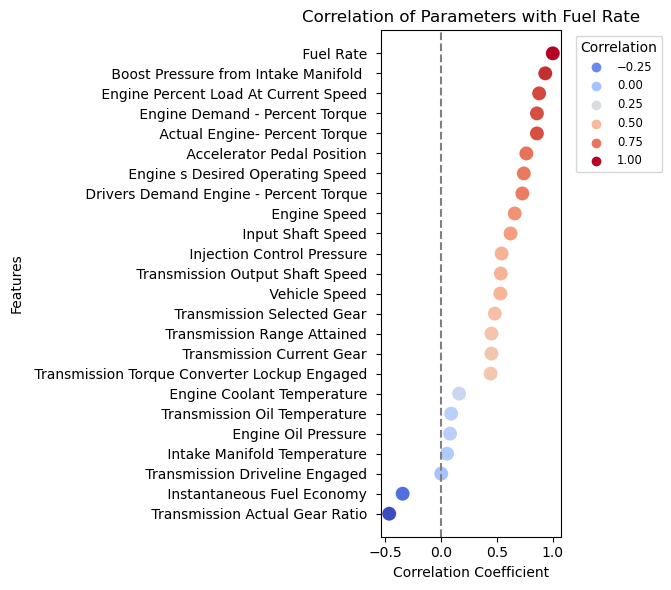

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Calculate correlations
correlation = df_2017_2018_selected_preprocessed.corr()['FuelRate'].sort_values(ascending=False)

# Prepare the data for plotting
correlation_data = pd.DataFrame(correlation).reset_index()
correlation_data.columns = ['Feature', 'Correlation']

# Plotting
plt.figure(figsize=(7, 6))  # Adjust figure size as needed to fit in the report
# Create a dot plot
sns.scatterplot(data=correlation_data, y='Feature', x='Correlation', hue='Correlation', palette='coolwarm', s=100, edgecolor="none")

# Adding a vertical line at x=0 for reference
plt.axvline(x=0, color='grey', linestyle='--')
#change y axis font size
plt.yticks(fontsize=10)
# Enhance readability and aesthetics
plt.title('Correlation of Parameters with Fuel Rate')
plt.xlabel('Correlation Coefficient')
#features use df_channel_name_selected for y-label
# get the ylabel from the df_channel_name_selected dataframe using the keyword as index using Feature as the index
plt.yticks(ticks=range(len(correlation_data)), labels=df_channel_name_selected.set_index('Keyword').loc[correlation_data['Feature']]['channel_name'])

plt.ylabel('Features' )
plt.legend(title='Correlation', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Adjust legend positioning

plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()


The plot shows a correlation matrix that measures the linear relationship between the fuel rate and various other vehicle parameters. Positive correlations are represented by red dots, while negative correlations are indicated by blue dots. The size and color intensity of the dots correspond to the strength of the correlation. Parameters such as 'FuelRate' and 'BoostPres' have a strong positive correlation with the fuel rate, suggesting they increase together. In contrast, 'TrqAti', 'InstFuelEco', and 'TranActGearRatio' have a negative correlation with fuel rate, indicating that as these parameters increase, the fuel rate tends to decrease. 

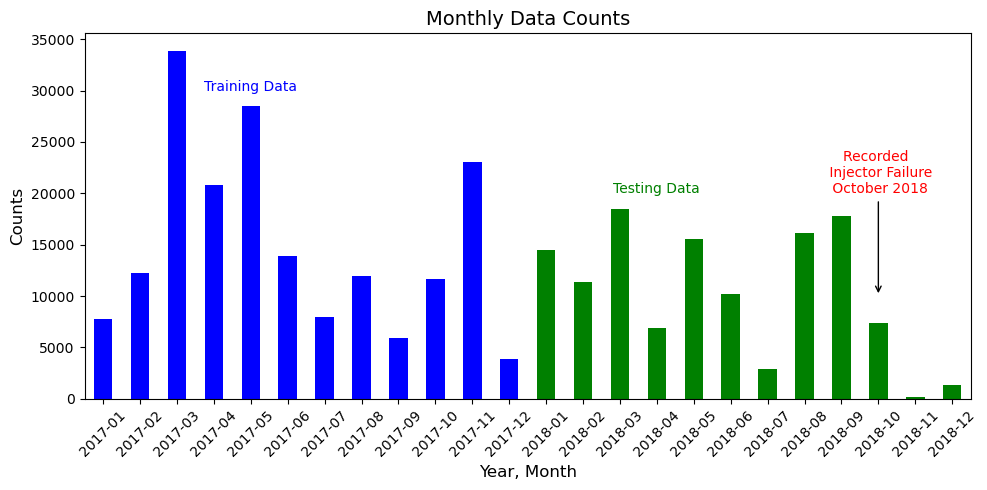

In [14]:

monthly_counts = df_2017_2018_selected_preprocessed.groupby([pd.Grouper(freq='M')]).size()

fig, ax = plt.subplots(figsize=(10, 5))

colors = ['blue' if x.year == 2017 else 'green' for x in monthly_counts.index]

monthly_counts.plot(kind='bar', color=colors, ax=ax)

plt.title('Monthly Data Counts', fontsize=14)
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Year, Month', fontsize=12)
plt.xticks(rotation=45)

xtick_labels = monthly_counts.index.strftime('%Y-%m')
ax.set_xticklabels(xtick_labels, fontsize=10)

injector_failure_index = list(xtick_labels).index('2018-10')  # Adjusted for accurate positioning
training_data_index = list(xtick_labels).index('2017-05')
testing_data_index = list(xtick_labels).index('2018-04')

# Annotations for Training and Testing Data
plt.text(training_data_index, 30000, 'Training Data', rotation=0, color='blue', ha='center')
plt.text(testing_data_index, 20000, 'Testing Data', rotation=0, color='green', ha='center')

# Annotation with arrow for Injector Failure
# plt.annotate('Injector Failure', xy=(injector_failure_index, 20000), xytext=(injector_failure_index, 25000),
#              arrowprops=dict(facecolor='red', shrink=0.05, arrowstyle="->"), rotation=90, color='red', ha='center')

# Annotation with arrow for Injector Failure
plt.annotate('Recorded \n Injector Failure\n October 2018', xy=(injector_failure_index, 10000), xytext=(injector_failure_index, 20000),
             arrowprops=dict(facecolor='red', arrowstyle="->"), rotation=0, color='red', ha='center')

plt.tight_layout()
plt.show()



In [16]:
df_2017_2018_selected_preprocessed.columns

Index(['AccelPedalPos', 'BoostPres', 'EngCoolantTemp', 'EngDesiredOpSpd',
       'EngDmdPctTorq', 'EngOilPres', 'EngPctLdAtCurSpd', 'EngPctTorq',
       'EngSpeed', 'FuelRate', 'InjCtlPres', 'InpSftSp', 'InstFuelEco',
       'IntManfTemp', 'PctEngLoad', 'TranActGearRato', 'TransCurGear',
       'TransDrivEng', 'TransOilTemp', 'TransOptShaftSpeedTrans_1587',
       'TransTorqConvLockupEngaged', 'TrRgAttai', 'TrSelGr', 'VehSpeedEng'],
      dtype='object')

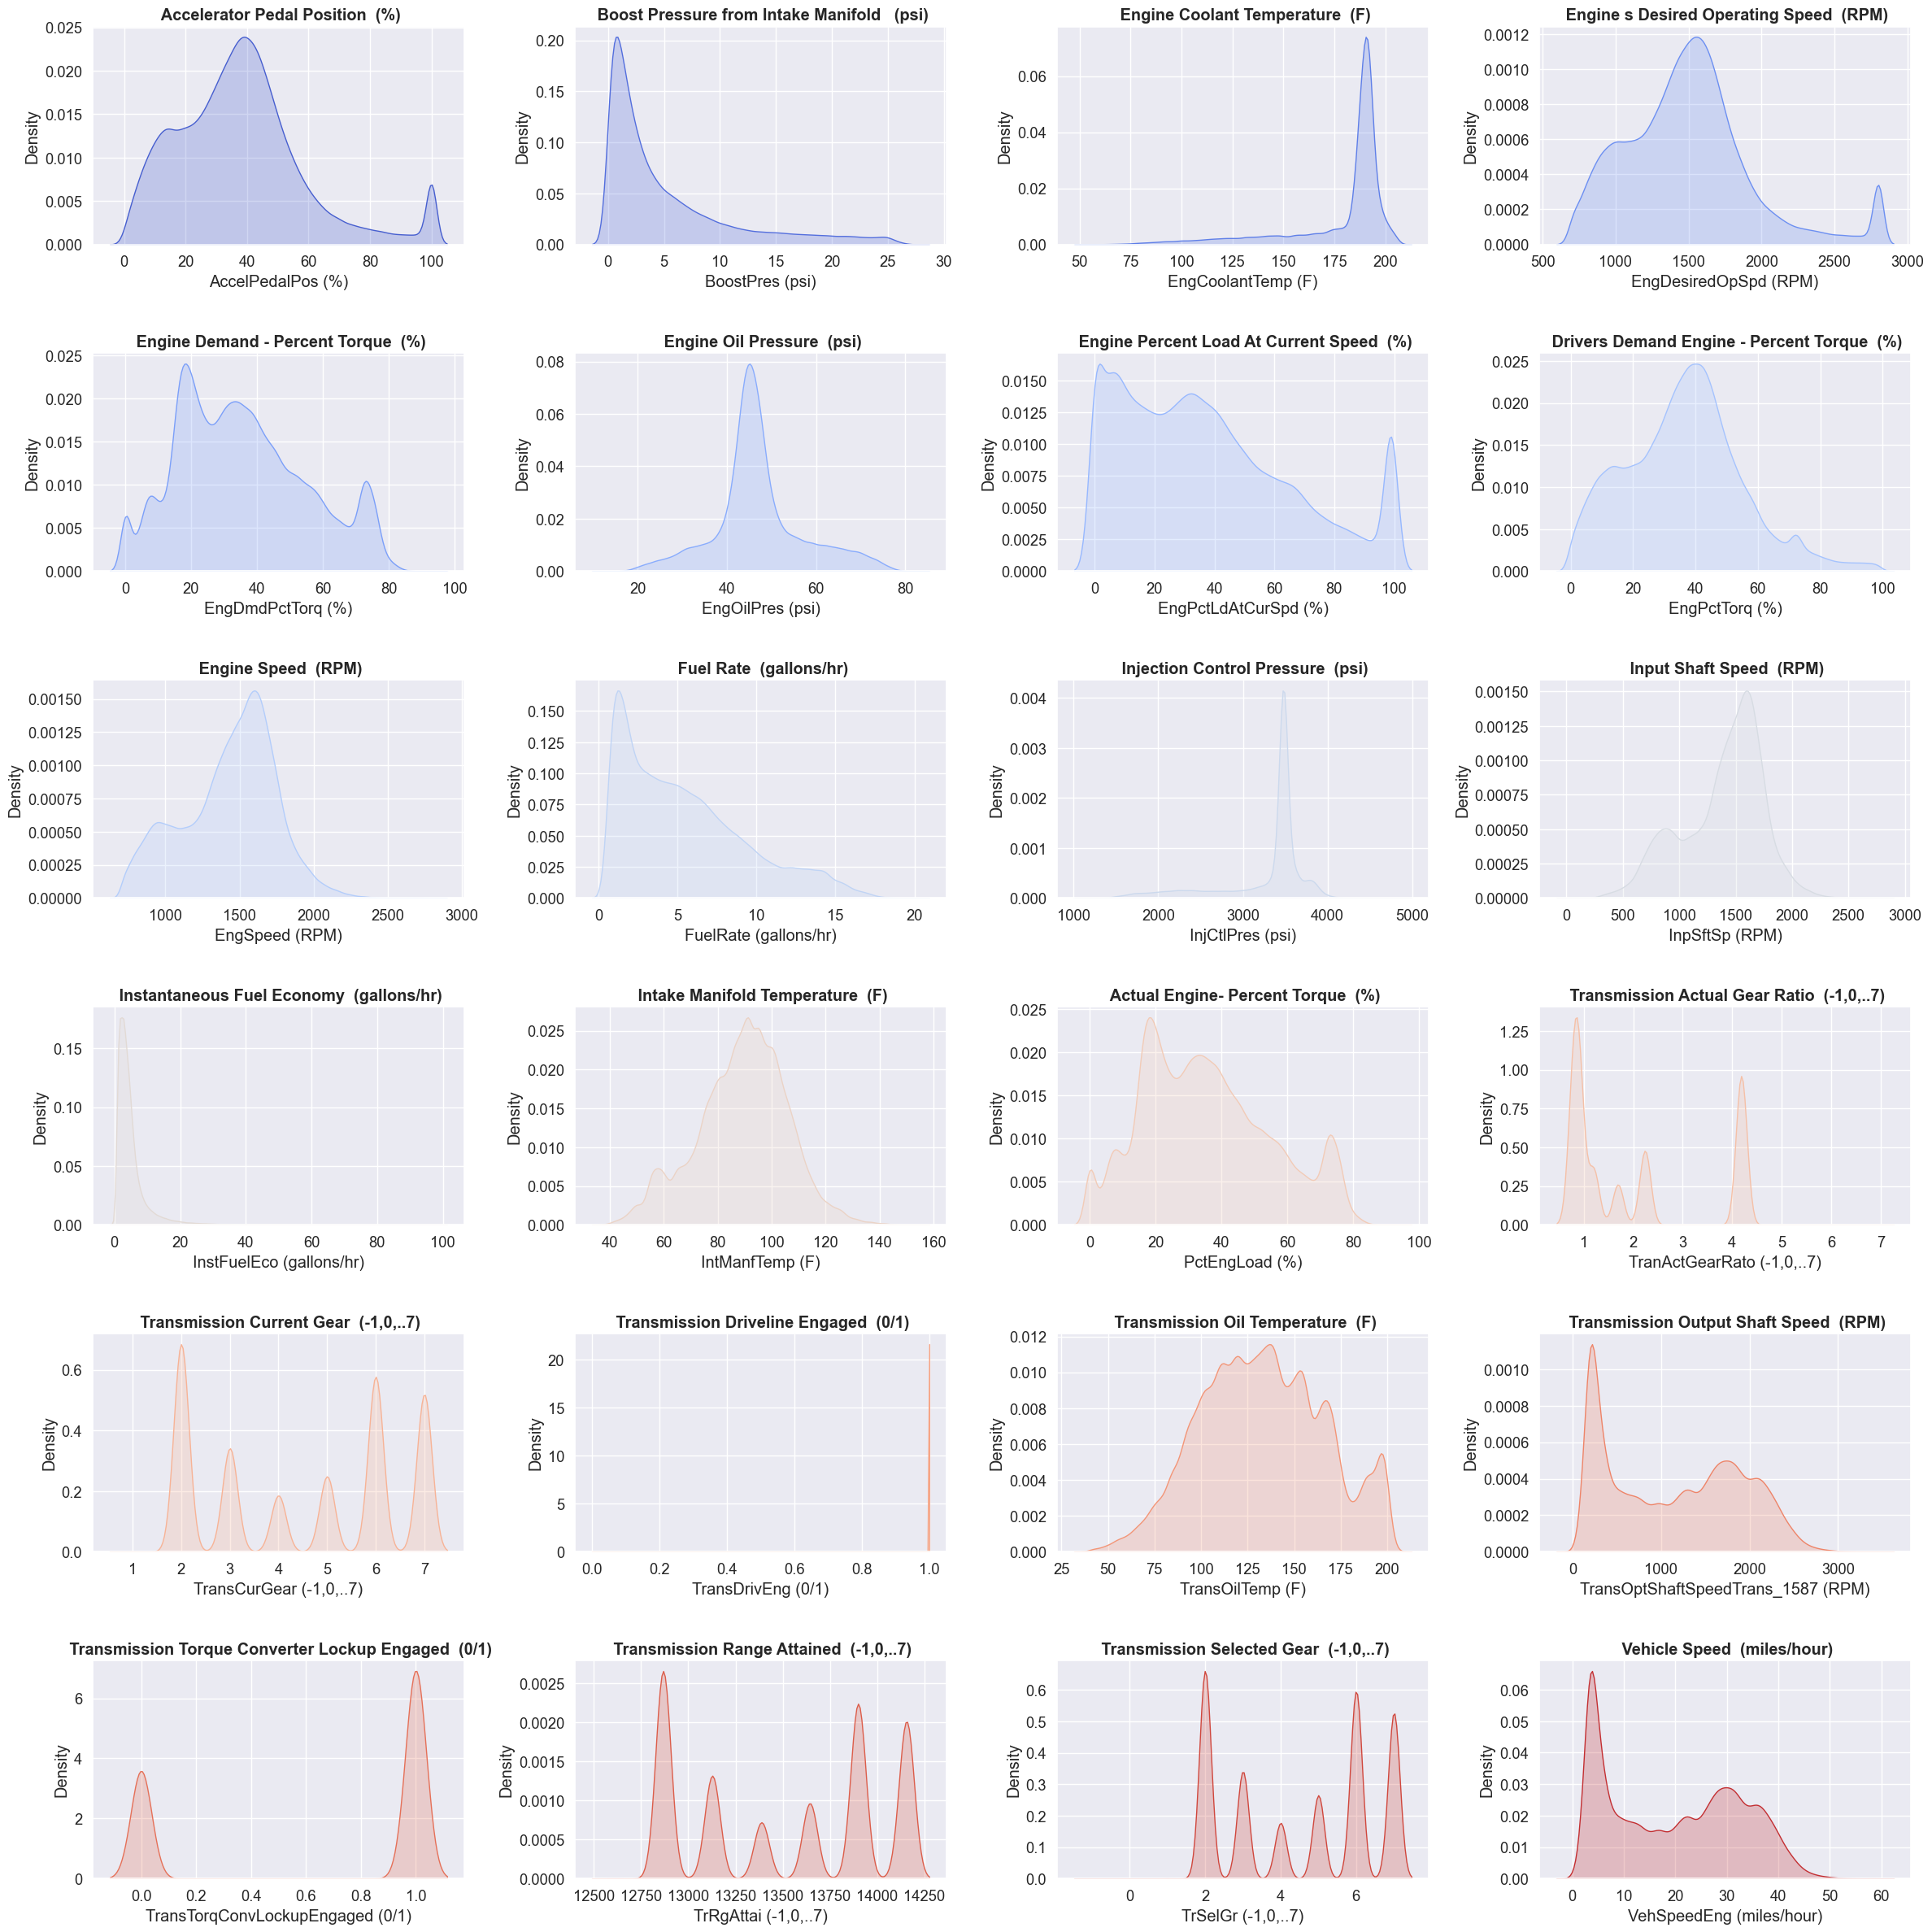

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

def enhanced_kde_plot_optimized(df, df_channel_name_selected):
    sns.set_style("whitegrid")
    sns.set(font="Arial", font_scale=1.2)  # Apply font settings globally
    palette = sns.color_palette("coolwarm", n_colors=len(df.columns))
    
    # Calculate the number of rows and columns for the subplots
    n_cols = 4  # You can adjust this to fit your preference or layout
    n_rows = math.ceil(len(df.columns) / n_cols)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(24, 4*n_rows))
    axs = axs.ravel()
    
    # Preprocess channel names and measurement units for efficiency
    channel_info = df_channel_name_selected.set_index('Keyword')[['channel_name', 'Measurement_Unit']].to_dict('index')
    
    for i, col in enumerate(df.columns):
        # Efficiently fetch channel name and measurement unit
        channel_name = channel_info[col]['channel_name']
        measurement_unit = channel_info[col]['Measurement_Unit']
        
        # Check for variance
        if df[col].nunique() > 1:  # Plot KDE if there's variance
            sns.kdeplot(data=df, x=col, fill=True, ax=axs[i], color=palette[i])
        else:  # Handle the zero variance case
            axs[i].text(0.5, 0.5, 'No variance\nin data', ha='center', va='center', transform=axs[i].transAxes)
            axs[i].set_facecolor('#f0f0f0')  # Optional: Change background color
        
        axs[i].set_title(f"{channel_name} ({measurement_unit})", fontweight='bold')
        axs[i].set_xlabel(f"{col} ({measurement_unit})")
        axs[i].set_ylabel('Density')
        axs[i].grid(True)
    
    # Hide any unused subplots
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    plt.show()


enhanced_kde_plot_optimized(df_2017_2018_selected_preprocessed, df_channel_name_selected)

Here are observations from the histograms:

1. **Accelerator Pedal Position (%)**: The histogram shows a bimodal distribution, indicating two common positions at which the accelerator pedal tends to be held, with peaks around 20% and 75%.

2. **Boost Pressure/Engine Intake Manifold #1 Pressure (psi)**: The boost pressure has a skewed distribution with most values occurring at the lower end of the scale, peaking at around 5 psi.

3. **Engine Coolant Temperature (F)**: This parameter shows a unimodal distribution with a peak at approximately 190°F, suggesting that this is the common operating temperature for the engine coolant.

4. **Engine's Desired Operating Speed (RPM)**: The histogram indicates a unimodal distribution with the most frequent desired operating speed around 2100 RPM.

5. **Engine Demand - Percent Torque**: The distribution is bimodal, with peaks near 20% and 80%, indicating two predominant levels of engine torque demand.

6. **Engine Oil Pressure (psi)**: The oil pressure shows a normal distribution, peaking at around 40 psi.

7. **Engine Percent Load At Current Speed**: This metric has a bimodal distribution, suggesting there are two common load percentages at the current speed, with peaks at around 20% and 60%.

8. **Drivers Demand Engine - Percent Torque**: The distribution is bimodal, closely matching the 'Engine Demand - Percent Torque' histogram.

9. **Engine Speed (RPM)**: The histogram shows a normal distribution with a peak around 1500 RPM.

10. **Fuel Rate (gallons/h)**: This parameter has a skewed distribution with most values at the lower end, peaking near 3 gallons/h.

11. **Injection Control Pressure (psi)**: The histogram is skewed right, with most occurrences at the lower end and a peak around 1200 psi.

12. **Input Shaft Speed (RPM)**: This follows a normal distribution with a peak at approximately 1500 RPM.

13. **Instantaneous Fuel Economy (gallons/h)**: This parameter has a right-skewed distribution with a peak at around 20 gallons/h.

14. **Intake Manifold Temperature (F)**: The histogram shows a normal distribution with a peak at around 100°F.

15. **Actual Engine - Percent Torque**: This distribution is skewed to the right, with most values occurring at the lower end.

16. **Transmission Actual Gear Ratio (1.0-7.0)**: The histogram displays a multimodal distribution, indicating frequent use of specific gear ratios.

17. **Transmission Current Gear (1.0-7.0)**: This shows a similar multimodal pattern to the 'Transmission Actual Gear Ratio', indicating that certain gears are more commonly engaged.

18. **Transmission Driveline Engaged (0/1)**: The bimodal distribution indicates that the driveline is either engaged or not, with equal frequency.

19. **Transmission Oil Temperature (F)**: The histogram shows a skewed right distribution, with most occurrences at lower temperatures.

20. **Transmission Output Shaft Speed (RPM)**: The histogram is skewed right, with the peak around 500 RPM.

21. **Transmission Torque Converter Lockup Engaged (0/1)**: This parameter shows a distribution with two spikes, indicating two states: locked and unlocked.

22. **Transmission Range Attained (0-6)**: The histogram exhibits a multimodal distribution, suggesting that certain transmission ranges are selected more frequently than others.

23. **Transmission Selected Gear (1.0-7.0)**: Similar to the 'Transmission Current Gear', this histogram shows a multimodal distribution, indicating preference for specific gears.

24. **Vehicle Speed (miles/hour)**: The histogram for vehicle speed shows a right-skewed distribution with most values clustering at the lower end, indicating that the vehicle is often driven at lower speeds.

These observations indicate the common operational states and behaviors of the vehicle across various parameters. The bimodal distributions suggest that there are specific preferred or more efficient operating points for the accelerator pedal, engine torque demand, and gear selection. The right-skewed distributions for parameters such as fuel rate, injection control pressure, and transmission oil temperature suggest that lower values are more common, but there are instances of higher readings that could be due to specific driving conditions or demands on the vehicle. The normal distributions seen in engine speed and intake manifold temperature indicate a consistency in the operation around a central tendency, which could imply a stable and typical operating condition for these parameters.

Each of these parameters can be further analyzed to assess vehicle performance, fuel efficiency, and potential maintenance needs. The data also provides insights into driving patterns, which can be used to optimize vehicle operation and maintenance schedules.

In [18]:
#create the table df_2017_2018_selected_preprocessed.columns matched with df_channel_name_selected['Keyword'] and measurement unit
df_channel_name_selected_table  = df_channel_name_selected[df_channel_name_selected['Keyword'].isin(df_2017_2018_selected_preprocessed.columns)]
df_channel_name_selected_table 

Keyword  \
0                  AccelPedalPos   
2                      BoostPres   
5                 EngCoolantTemp   
7                EngDesiredOpSpd   
8                  EngDmdPctTorq   
9                     EngOilPres   
11              EngPctLdAtCurSpd   
12                    EngPctTorq   
15                      EngSpeed   
16                      FuelRate   
17                    InjCtlPres   
19                      InpSftSp   
20                   InstFuelEco   
21                   IntManfTemp   
23                    PctEngLoad   
29               TranActGearRato   
30                  TransCurGear   
31                  TransDrivEng   
32                  TransOilTemp   
33  TransOptShaftSpeedTrans_1587   
34    TransTorqConvLockupEngaged   
35                     TrRgAttai   
36                       TrSelGr   
37                   VehSpeedEng   

                                      channel_name Measurement_Unit  
0                      Accelerator Pedal Position                 %  
2            Boost Pressure from Intake Manifold                psi  
5                      Engine Coolant Temperature                 F  
7                Engine s Desired Operating Speed               RPM  
8                  Engine Demand - Percent Torque                 %  
9                             Engine Oil Pressure               psi  
11           Engine Percent Load At Current Speed                 %  
12         Drivers Demand Engine - Percent Torque                 %  
15                                   Engine Speed               RPM  
16                                      Fuel Rate        gallons/hr  
17                     Injection Control Pressure               psi  
19                              Input Shaft Speed               RPM  
20                     Instantaneous Fuel Economy        gallons/hr  
21                    Intake Manifold Temperature                 F  
23                  Actual Engine- Percent Torque                 %  
29                 Transmission Actual Gear Ratio          -1,0,..7  
30                      Transmission Current Gear          -1,0,..7  
31                 Transmission Driveline Engaged               0/1  
32                   Transmission Oil Temperature                 F  
33                Transmission Output Shaft Speed               RPM  
34   Transmission Torque Converter Lockup Engaged               0/1  
35                    Transmission Range Attained          -1,0,..7  
36                     Transmission Selected Gear          -1,0,..7  
37                                  Vehicle Speed        miles/hour

| Feature           | Feature Name                          | Description                                                       | Measurement_Unit |
|-------------------|---------------------------------------|-------------------------------------------------------------------|------------------|
| AccelPedalPos     | Accelerator Pedal Position            | Measures the degree to which the accelerator pedal is depressed, indicating power demand. | %                |
| BoostPres         | Boost Pressure/Engine Intake Manifold #1 Pres... | Indicates intake manifold pressure in turbocharged/supercharged engines, relating to power output. | psi              |
| EngCoolantTemp    | Engine Coolant Temperature            | Monitors the temperature of the coolant fluid to prevent engine overheating. | F                |
| EngDesiredOpSpd   | Engine's Desired Operating Speed      | Target engine speed set by the ECU for optimal performance/efficiency. | RPM              |
| EngDmdPctTorq     | Engine Demand - Percent Torque        | Percentage of maximum available torque currently being requested from the engine. | %                |
| EngOilPres        | Engine Oil Pressure                   | Measures the engine oil pressure, crucial for proper engine lubrication. | psi              |
| EngPctLdAtCurSpd  | Engine Percent Load At Current Speed  | Percentage load on the engine at the current speed, showing engine workload. | %                |
| EngPctTorq        | Drivers Demand Engine - Percent Torque| Percentage of torque requested by the driver, reflects throttle position. | %                |
| EngSpeed          | Engine Speed                          | Rotational speed of the engine's crankshaft, measured in RPM.    | RPM              |
| FuelRate          | Fuel Rate                             | Rate of fuel consumption by the engine, in gallons per hour.     | gallons/hr       |
| InjCtlPres        | Injection Control Pressure            | Pressure in the fuel injection system, affecting engine performance. | psi              |
| InpSftSp          | Input Shaft Speed                     | Speed of the transmission input shaft, influenced by engine speed. | RPM              |
| InstFuelEco       | Instantaneous Fuel Economy            | Instantaneous fuel economy, efficiency of fuel use at a specific moment. | gallons/hr       |
| IntManfTemp       | Intake Manifold Temperature           | Temperature of the air within the intake manifold, affects combustion efficiency. | F                |
| PctEngLoad        | Actual Engine- Percent Torque         | Current engine load as a percentage of maximum capacity.         | %                |
| TranActGearRato   | Transmission Actual Gear Ratio        | Current gear ratio used by the transmission for power transfer.  | -1,0,..7         |
| TransCurGear      | Transmission Current Gear             | Current gear engaged by the vehicle's transmission.              | -1,0,..7         |
| TransDrivEng      | Transmission Driveline Engaged        | Binary indication of driveline being engaged or disengaged.      | 0/1              |
| TransOilTemp      | Transmission Oil Temperature          | Temperature of the transmission oil, important for transmission efficiency. | F                |
| TransOptShaftSpeedTrans_1587 | Transmission Output Shaft Speed | Speed of transmission's output shaft, affects wheel speed and velocity. | RPM              |
| TransTorqConvLockupEngaged | Transmission Torque Converter Lockup Engaged | Engagement of torque converter lockup for improved fuel efficiency. | 0/1              |
| TrRgAttai         | Transmission Range Attained           | Range of transmission gears attained, refers to gear ratio availability. | -1,0,..7         |
| TrSelGr           | Transmission Selected Gear            | Gear currently selected by the transmission system.              | -1,0,..7         |
| VehSpeedEng       | Vehicle Speed                         | Vehicle speed measured in miles per hour.                        | miles/hour       |


# Data for Model Development

In [19]:
#Separate data as 2017
df_2017 = df_2017_2018_selected_preprocessed[(df_2017_2018_selected_preprocessed.index > '2017-01-01') & (df_2017_2018_selected_preprocessed.index < '2018-01-01')]
#2018 data
df_2018 = df_2017_2018_selected_preprocessed[(df_2017_2018_selected_preprocessed.index > '2018-01-01') & (df_2017_2018_selected_preprocessed.index < '2019-01-01')]

#shapes of the data
print('Shape of the 2017 data:', df_2017.shape)
print('Shape of the 2018 data:', df_2018.shape)



Shape of the 2017 data: (181280, 24)
Shape of the 2018 data: (122811, 24)


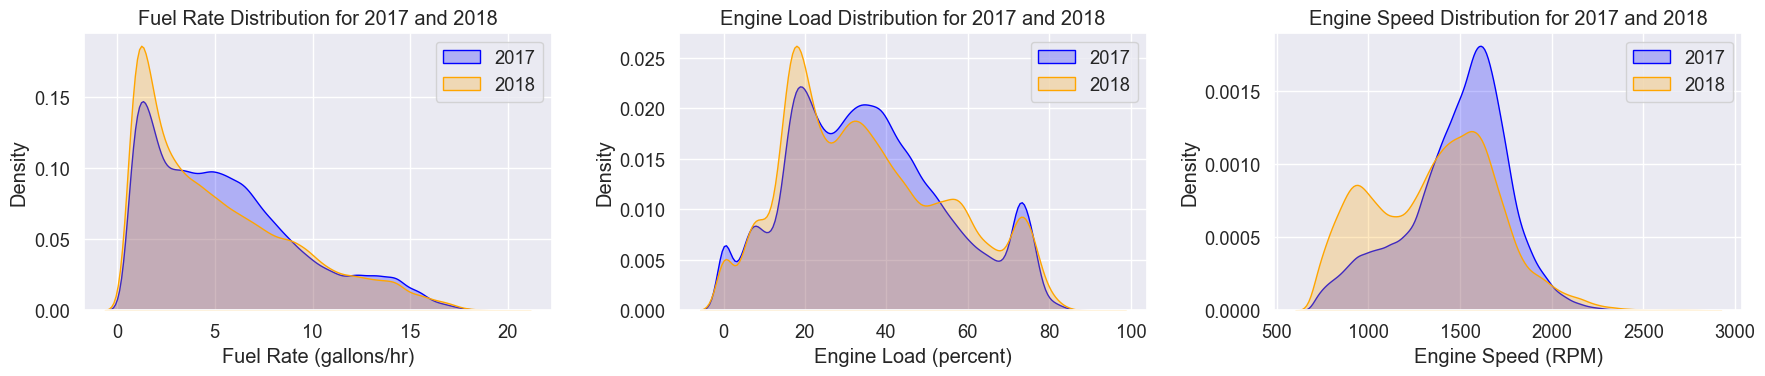

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setup for combined plot in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns

# Plot Fuel Rate Distribution
sns.kdeplot(df_2017['FuelRate'], label='2017', fill=True, ax=axes[0], color='blue')
sns.kdeplot(df_2018['FuelRate'], label='2018', fill=True, ax=axes[0], color='orange')
axes[0].set_title('Fuel Rate Distribution for 2017 and 2018')
axes[0].set_xlabel('Fuel Rate (gallons/hr)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot Engine Load Distribution
sns.kdeplot(df_2017['PctEngLoad'], label='2017', fill=True, ax=axes[1], color='blue')
sns.kdeplot(df_2018['PctEngLoad'], label='2018', fill=True, ax=axes[1], color='orange')
axes[1].set_title('Engine Load Distribution for 2017 and 2018')
axes[1].set_xlabel('Engine Load (percent)')
axes[1].set_ylabel('Density')
axes[1].legend()

# Plot Engine Speed Distribution
sns.kdeplot(df_2017['EngSpeed'], label='2017', fill=True, ax=axes[2], color='blue')
sns.kdeplot(df_2018['EngSpeed'], label='2018', fill=True, ax=axes[2], color='orange')
axes[2].set_title('Engine Speed Distribution for 2017 and 2018')
axes[2].set_xlabel('Engine Speed (RPM)')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()


In [126]:
#write the df_2017 and df_2018 to parquet
# df_2017.to_parquet('df_2017.parquet')
# df_2018.to_parquet('df_2018.parquet')

# #Write the df_channel_name_selected_table to parquet
# df_channel_name_selected_table.to_parquet('df_channel_name_selected_table.parquet')
# #read the df_channel_name_selected_table
# df_channel_name_selected_table = pd.read_parquet('df_channel_name_selected_table.parquet')

#read the parquet file
df_2017 = pd.read_parquet('df_2017.parquet')
df_2018 = pd.read_parquet('df_2018.parquet')


# Feature Extraction


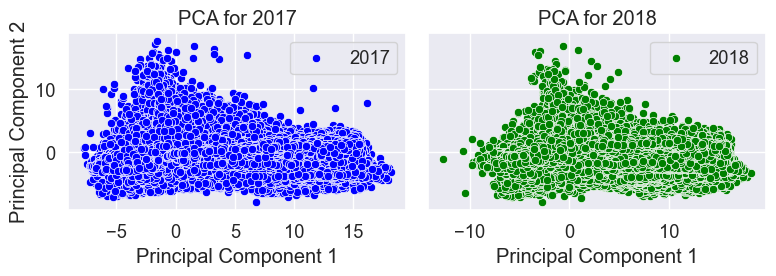

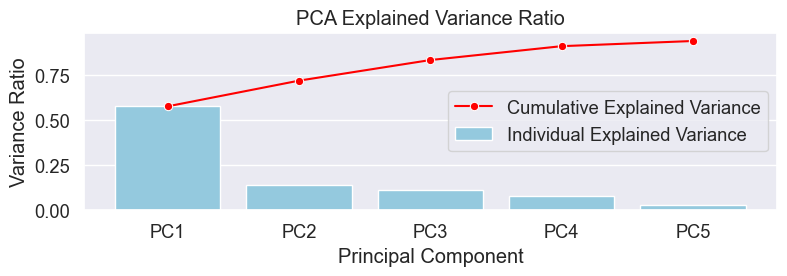

Explained Variance Ratio: [0.5763049  0.14250366 0.11424378 0.07696016 0.02867282]
Cumulative Explained Variance: [0.5763049  0.71880856 0.83305233 0.9100125  0.93868532]


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_2017 and df_2018 are predefined datasets

# Standardize the data
scaler = RobustScaler()
df_2017_scaled = scaler.fit_transform(df_2017)
df_2018_scaled = scaler.transform(df_2018)

# Fit PCA with 5 components
pca = PCA(n_components=5)
df_2017_pca = pca.fit_transform(df_2017_scaled)
df_2018_pca = pca.transform(df_2018_scaled)

# Visualizing PCA for the first two principal components for 2017 and 2018
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(x=df_2017_pca[:, 0], y=df_2017_pca[:, 1], ax=axes[0], color='blue', label='2017').set(title='PCA for 2017', xlabel='Principal Component 1', ylabel='Principal Component 2')
sns.scatterplot(x=df_2018_pca[:, 0], y=df_2018_pca[:, 1], ax=axes[1], color='green', label='2018').set(title='PCA for 2018', xlabel='Principal Component 1')
plt.tight_layout()

# Explained Variance Ratio and Cumulative Explained Variance
explained_variance_ratio_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(5)], 
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Explained Variance': pca.explained_variance_ratio_.cumsum()
})

plt.figure(figsize=(8, 3))
sns.barplot(data=explained_variance_ratio_df, x='Principal Component', y='Explained Variance Ratio', color='skyblue', label='Individual Explained Variance')
sns.lineplot(data=explained_variance_ratio_df, x='Principal Component', y='Cumulative Explained Variance', marker='o', sort=False, color='red', label='Cumulative Explained Variance').set(title='PCA Explained Variance Ratio')
plt.ylabel('Variance Ratio')
plt.legend()
plt.tight_layout()
plt.show()

# Output the explained variance metrics
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.cumsum())


Explained Variance Ratio: [0.5763049  0.14250366 0.11424378 0.07696016 0.02867282]
Cumulative Explained Variance: [0.5763049  0.71880856 0.83305233 0.9100125  0.93868532]



## Supervised Learning

In supervised learning, the team developed and evaluated predictive models for estimating fuel rates based on historical data gathered in 2017 and 2018. Year 2017 data was used for training the model.  Utilizing Python libraries such as NumPy, pandas, and scikit-learn, the analysis began with the preparation of datasets, focusing on selected features while excluding the 'FuelRate' column as the target variable. A RobustScaler was applied to standardize the feature values, enhancing the models' robustness against outliers.

Three predictive models—Polynomial Regression,random forest, and MLP Regressor—were considered for comparison. Additionally, Polynomial Features transformation was employed to explore non-linear relationships, with a custom function facilitating the evaluation of polynomial degrees against the Linear Regression model. Cross-validation scores were computed to assess model performance, employing R-squared as the scoring metric for its interpretability in explaining variance.



In [129]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
import csv

# Load df_2017 and df_2018 before this step

df_2017_sample = df_2017.sample(10000)
df_2018_sample = df_2018.sample(10000)

X_train = df_2017_sample.drop(columns=['FuelRate'])
y_train = df_2017_sample['FuelRate']

X_test = df_2018_sample.drop(columns=['FuelRate'])
y_test = df_2018_sample['FuelRate']

#Robust scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)





# Define a function to scale and split the data
def scale_and_split_data(df_train, df_test, target_column='FuelRate', sample_size=1000):
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(df_train.drop(columns=[target_column]))[:sample_size]
    y_train = df_train[target_column][:sample_size]
    X_test_scaled = scaler.transform(df_test.drop(columns=[target_column]))[:sample_size]
    y_test = df_test[target_column][:sample_size]
    return X_train_scaled, y_train, X_test_scaled, y_test


# Logging function

import csv
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime

def log_to_csv_and_console(message, log_file='log.csv'):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_message = f"{timestamp} - {message}"
    print(log_message)
    with open(log_file, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([log_message])

# Ploynomial function
def poly_regression(X_train, y_train, degrees, cv_fold=5, scoring='r2'):
    best_score = -np.inf
    best_degree = None

    for degree in degrees:
        # Transform input data
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        
        # Initialize and cross-validate model
        model = LinearRegression()
        scores = cross_val_score(model, X_train_poly, y_train, cv=cv_fold, scoring=scoring, n_jobs=-1)
        score = np.mean(scores)
        
        # Logging
        log_to_csv_and_console(f"[Polynomial Linear Regression] Degree: {degree}, Score: {score:.4f}")
        
        # Track the best score and corresponding degree
        if score > best_score:
            best_score = score
            best_degree = degree

    # Log the best configuration
    log_to_csv_and_console(f"[Polynomial Linear Regression] Best score: {best_score:.4f} using degree {best_degree}")
    return best_degree, best_score


#  poly_regression (ensure you have X_train_scaled and y_train prepared)
degrees = range(1, 3)  #
best_degree, best_score = poly_regression(X_train_scaled, y_train, degrees, cv_fold=5, scoring='r2')
print(f"Best degree: {best_degree}, Best score: {best_score:.4f}")

# Results - 10000 samples
# 2024-03-03 15:49:43 - [Polynomial Linear Regression] Degree: 1, Score: 0.9621
# 2024-03-03 15:49:44 - [Polynomial Linear Regression] Degree: 2, Score: -11168491617091.4648
# 2024-03-03 15:49:56 - [Polynomial Linear Regression] Degree: 3, Score: -5.8626
# Best degree: 1, Best score: 0.9390

The polynomial regression analysis revealed that a first-degree polynomial (linear model) achieved the best performance with an R-squared score of 0.96, indicating a high explanatory power over the fuel rate variance. Higher-degree polynomials resulted in negative scores, suggesting overfitting and a loss in predictive accuracy. 


In [130]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def random_forest_regression(X_train, y_train, param_grid, cv_fold=5, scoring='r2'):
    # Initialize the Random Forest regressor
    rf = RandomForestRegressor(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv_fold, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Log the best configuration
    log_to_csv_and_console(f"[Random Forest Regression] Best score: {grid_search.best_score_:.4f} using {grid_search.best_params_}")
    
    return grid_search.best_params_, grid_search.best_score_

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at a leaf node
}

# Example call to random_forest_regression
best_params, best_score = random_forest_regression(X_train_scaled, y_train, param_grid, cv_fold=5, scoring='r2')
print(f"Best parameters: {best_params}, Best score: {best_score:.4f}")

# Results
# Fitting 5 folds for each of 108 candidates, totalling 540 fits
# 2024-02-27 16:28:57 - [Random Forest Regression] Best score: 0.9761 using {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Best score: 0.9761

Utilizing the scikit-learn library, the Random Forest Regressor was parameterized and evaluated through a systematic GridSearchCV approach, focusing on optimizing hyperparameters to enhance model performance. The selected hyperparameters included the number of trees in the forest (n_estimators), the maximum depth of the trees (max_depth), the minimum number of samples required to split an internal node (min_samples_split), and the minimum number of samples required at a leaf node (min_samples_leaf).

The grid search explored a combination of 108 different parameter settings over five-fold cross-validation to identify the configuration that maximizes the R-squared (r2) score, a metric chosen for its ability to quantify the proportion of variance in the dependent variable predictable from the independent variables.

The analysis concluded with the identification of the optimal parameter set, achieving an R-squared score of 0.9761, which indicates a high level of predictive accuracy. The best parameters were found to be 100 trees in the forest (n_estimators), no maximum depth (max_depth), a minimum of one sample required at a leaf node (min_samples_leaf), and a minimum of two samples required to split an internal node (min_samples_split). This configuration underscores the effectiveness of the Random Forest regressor in handling the dataset, providing insights into its application for predictive modeling tasks with high accuracy and interpretability.

In [131]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

def mlp_regression(X_train, y_train, param_grid, cv_fold=5, scoring='r2'):
    # Initialize the MLP regressor
    mlp = MLPRegressor(random_state=42, max_iter=1000)  # max_iter might need adjustment based on convergence
    
    # Perform grid search
    grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=cv_fold, scoring=scoring, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Log the best configuration
    log_to_csv_and_console(f"[MLPRegressor Neural Network] Best score: {grid_search.best_score_:.4f} using {grid_search.best_params_}")
    
    return grid_search.best_params_, grid_search.best_score_


param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Different architectures
    'activation': ['tanh', 'relu'],  # Activation functions
    'solver': ['sgd', 'adam'],  # Solver for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant','adaptive'],  # Learning rate schedule
}


# Example call to mlp_regression
best_params, best_score = mlp_regression(X_train_scaled, y_train, param_grid, cv_fold=5, scoring='r2')
print(f"Best parameters: {best_params}, Best score: {best_score:.4f}")

# Results
# Fitting 5 folds for each of 96 candidates, totalling 480 fits
# 2024-02-27 16:33:06 - [MLPRegressor Neural Network] Best score: 0.9852 using {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
# Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}, Best score: 0.9852

We implemented the MLPRegressor from the sklearn library, designed to perform regression tasks. We worked on optimizing the hyperparameters of the neural network through a systematic grid search approach. The mlp_regression function encapsulates the process of initializing the MLPRegressor, configuring the grid search with a predefined set of hyperparameters, and fitting the model to the training data. The hyperparameters explored include various configurations of hidden layer sizes, activation functions, solvers for weight optimization, L2 penalty parameters, and learning rate schedules. The grid search is executed with cross-validation to ensure the model's generalizability and is set to maximize the R-squared (R²) score as its performance metric.

The search concludes by identifying the optimal hyperparameter combination that yields the best R² score, logging this information for further analysis. In this instance, the best model configuration is achieved with the 'tanh' activation function, a very low alpha value (0.0001) indicating minimal regularization, a two-layer hidden architecture (50 neurons each), a constant learning rate, and the 'adam' solver for weight optimization. This configuration leads to an impressive R² score of 0.9852, indicating a very high level of predictive accuracy in the regression task.

This exploration demonstrates the efficacy of using grid search combined with cross-validation for hyperparameter tuning in neural network models, significantly improving model performance by methodically searching through a wide range of parameter combinations.

# Evaluation of the Models

In [82]:
df_channel_name_selected

Keyword  \
0                  AccelPedalPos   
1               BarPres_Eng_1587   
2                      BoostPres   
3                 BoostPres_1587   
4                   CoolantLevel   
5                 EngCoolantTemp   
6            EngCoolantTemp_1587   
7                EngDesiredOpSpd   
8                  EngDmdPctTorq   
9                     EngOilPres   
10               EngOilPres_1587   
11              EngPctLdAtCurSpd   
12                    EngPctTorq   
13                     EngRtdPwr   
14                   EngRtdSpeed   
15                      EngSpeed   
16                      FuelRate   
17                    InjCtlPres   
18              InjCtrlPres_1587   
19                      InpSftSp   
20                   InstFuelEco   
21                   IntManfTemp   
22              IntManfTemp_1587   
23                    PctEngLoad   
24                RtdEngPwr_1587   
25              RtdEngSpeed_1587   
26                     TotEngHrs   
27                TotEngHrs_1587   
28              TotIdlHours_1587   
29               TranActGearRato   
30                  TransCurGear   
31                  TransDrivEng   
32                  TransOilTemp   
33  TransOptShaftSpeedTrans_1587   
34    TransTorqConvLockupEngaged   
35                     TrRgAttai   
36                       TrSelGr   
37                   VehSpeedEng   

                                      channel_name Measurement_Unit  
0                      Accelerator Pedal Position                 %  
1                             Barometric Pressure               psi  
2            Boost Pressure from Intake Manifold                psi  
3                                  Boost Pressure               psi  
4                                   Coolant Level                 %  
5                      Engine Coolant Temperature                 F  
6                      Engine Coolant Temperature                 F  
7                Engine s Desired Operating Speed               RPM  
8                  Engine Demand - Percent Torque                 %  
9                             Engine Oil Pressure               psi  
10                            Engine Oil Pressure               psi  
11           Engine Percent Load At Current Speed                 %  
12         Drivers Demand Engine - Percent Torque                 %  
13                             Engine Rated Power        Horsepower  
14                             Engine Rated Speed               RPM  
15                                   Engine Speed               RPM  
16                                      Fuel Rate        gallons/hr  
17                     Injection Control Pressure               psi  
18                     Injection Control Pressure               psi  
19                              Input Shaft Speed               RPM  
20                     Instantaneous Fuel Economy        gallons/hr  
21                    Intake Manifold Temperature                 F  
22                    Intake Manifold Temperature                 F  
23                  Actual Engine- Percent Torque                 %  
24                             Rated Engine Power        Horsepower  
25                             Rated Engine Speed               RPM  
26                             Total Engine Hours             Hours  
27                             Total Engine Hours             Hours  
28                               Total Idle Hours             Hours  
29                 Transmission Actual Gear Ratio          -1,0,..7  
30                      Transmission Current Gear          -1,0,..7  
31                 Transmission Driveline Engaged               0/1  
32                   Transmission Oil Temperature                 F  
33                Transmission Output Shaft Speed               RPM  
34   Transmission Torque Converter Lockup Engaged               0/1  
35                    Transmission Range Attained          -1,0,..7  
36                     Transmi

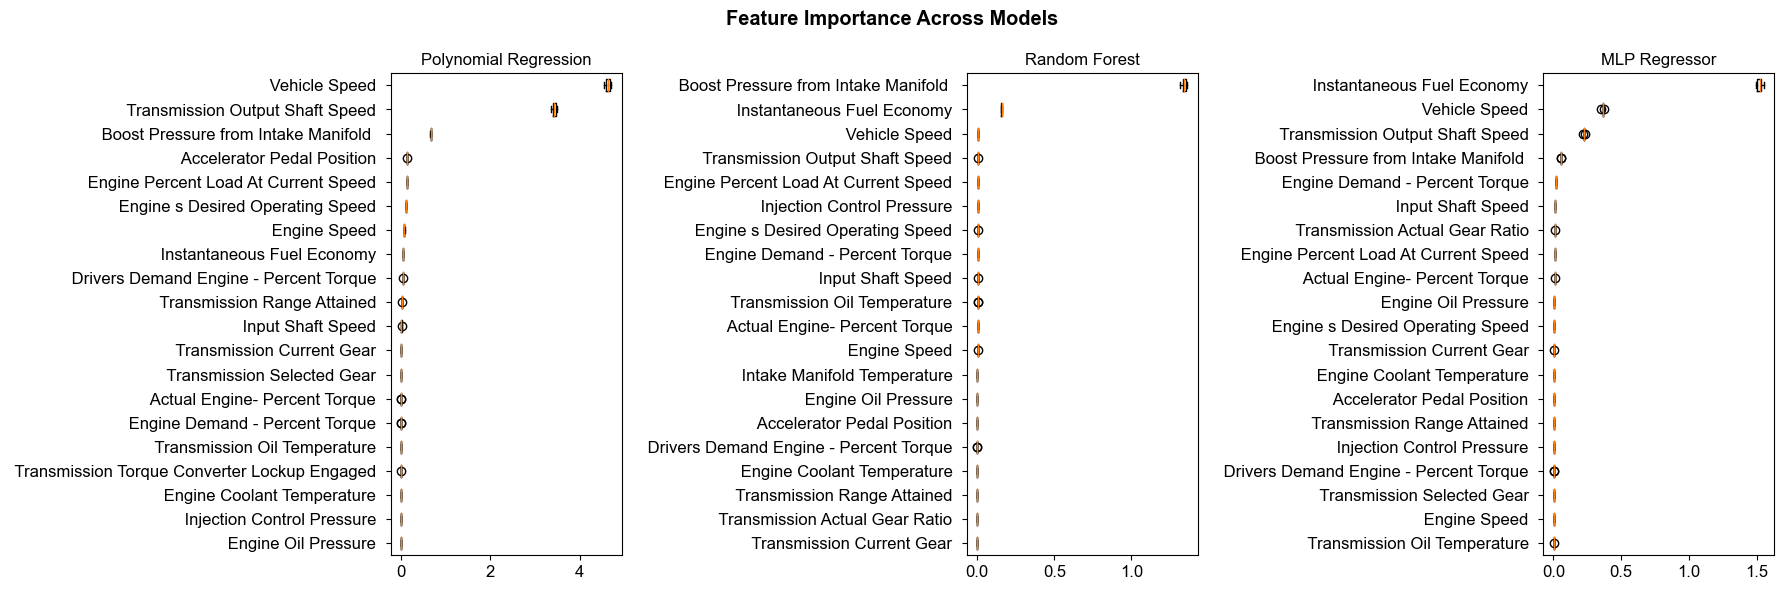

<Figure size 640x480 with 0 Axes>

Training Data Evaluation:
                    Model   MSE  R2 Score  MAPE
0  Polynomial Regression  0.53      0.96  0.17
1          Random Forest  0.03      1.00  0.02
2          MLP Regressor  0.10      0.99  0.06

Test Data Evaluation:
                    Model   MSE  R2 Score  MAPE
0  Polynomial Regression  1.16      0.93  0.20
1          Random Forest  0.74      0.95  0.09
2          MLP Regressor  0.24      0.98  0.09


In [128]:



import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data preparation
df_2017_sample = df_2017.sample(10000)
df_2018_sample = df_2018.sample(10000)
X_train = df_2017_sample.drop(columns=['FuelRate'])
y_train = df_2017_sample['FuelRate']
X_test = df_2018_sample.drop(columns=['FuelRate'])
y_test = df_2018_sample['FuelRate']

# Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameters
# # Define hyperparameters for each model
# poly_hyperparams = {'degree': 1}
# rf_hyperparams = {
#     'n_estimators': 100, 
#     'max_depth': None, 
#     'min_samples_split': 2,
#     'min_samples_leaf': 1, 
#     'random_state': 42}
# mlp_hyperparams = {
#     'hidden_layer_sizes': (50, 50), 
#     'activation': 'tanh', 
#     'solver': 'adam',
#     'alpha': 0.0001, 
#     'learning_rate': 'constant', 
#     'max_iter': 1000,
#     'random_state': 42}
poly_hyperparams = {'degree': 1}
rf_hyperparams = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42}
mlp_hyperparams = {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42}

# Model training and evaluation functions
def train_and_evaluate(X_train, y_train, X_test, y_test, train_func, hyperparams, is_poly=False):
    if is_poly:
        poly_features = PolynomialFeatures(degree=hyperparams['degree'])
        X_train_poly = poly_features.fit_transform(X_train)
        model = LinearRegression().fit(X_train_poly, y_train)
        X_test_poly = poly_features.transform(X_test)
    else:
        model = train_func(X_train, y_train, hyperparams)
        poly_features = None
    
    # Evaluate
    train_metrics = evaluate_model(model, X_train, y_train, poly_features)
    test_metrics = evaluate_model(model, X_test, y_test, poly_features)
    return model, poly_features, train_metrics, test_metrics

def train_rf_regression(X_train, y_train, hyperparams):
    return RandomForestRegressor(**hyperparams).fit(X_train, y_train)

def train_mlp_regression(X_train, y_train, hyperparams):
    return MLPRegressor(**hyperparams).fit(X_train, y_train)

def evaluate_model(model, X, y, poly_features=None):
    if poly_features is not None:
        X = poly_features.transform(X)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    return mse, r2, mape

# Train, evaluate, and calculate feature importance
evaluation_results_train = []
evaluation_results_test = []

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Feature Importance Across Models', fontweight='bold')

models = {
    "Polynomial Regression": (train_and_evaluate, poly_hyperparams, True),
    "Random Forest": (train_rf_regression, rf_hyperparams, False),
    "MLP Regressor": (train_mlp_regression, mlp_hyperparams, False)
}

  
def plot_permutation_importance(model, X, y, ax, feature_names, title, df_channel_name_selected, top_n_features=20):
    # Calculate permutation importance
    results = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = results.importances_mean.argsort()
    if top_n_features > len(sorted_idx):
        top_n_features = len(sorted_idx)
    sorted_idx_top = sorted_idx[-top_n_features:]
    
    # Extract the feature names based on sorted importance indices
    sorted_feature_names = [feature_names[i] for i in sorted_idx_top] if feature_names is not None else sorted_idx_top
    
    # Map sorted_feature_names to 'Keyword' in df_channel_name_selected and extract corresponding 'channel_name'
    channel_labels = df_channel_name_selected.set_index('Keyword').loc[sorted_feature_names]['channel_name'].tolist()

    # Plot the permutation importance with the extracted channel names as labels
    ax.boxplot(results.importances[sorted_idx_top].T, vert=False, labels=channel_labels)
    ax.set_title(title, fontsize=12, fontfamily='Arial')
 
def plot_permutation_importance_improved(model, X, y, ax, feature_names, title, df_channel_name_selected, top_n_features=20):
    # Calculate permutation importance
    results = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = results.importances_mean.argsort()[-top_n_features:]
    
    # Extract sorted importance scores and corresponding feature names
    sorted_importances = results.importances_mean[sorted_idx]
    sorted_feature_names = np.array(feature_names)[sorted_idx]
    
    # Map sorted_feature_names to 'Keyword' in df_channel_name_selected and extract corresponding 'channel_name'
    channel_labels = df_channel_name_selected.set_index('Keyword').loc[sorted_feature_names]['channel_name'].values
    
    # Create horizontal bar plot for improved visualization
    ax.barh(range(len(sorted_idx)), sorted_importances, color='skyblue')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels(channel_labels)
    ax.set_title(title)
    ax.set_xlabel('Mean Importance Score')

##################

for i, (model_name, (train_func, hyperparams, is_poly)) in enumerate(models.items()):
    model, poly_features, train_metrics, test_metrics = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, train_func, hyperparams, is_poly)
    evaluation_results_train.append({'Model': model_name, 'MSE': train_metrics[0], 'R2 Score': train_metrics[1], 'MAPE': train_metrics[2]})
    evaluation_results_test.append({'Model': model_name, 'MSE': test_metrics[0], 'R2 Score': test_metrics[1], 'MAPE': test_metrics[2]})
    
    # Prepare feature names for plotting
    if is_poly and poly_features is not None:
        feature_names = poly_features.get_feature_names_out(input_features=X_train.columns)
    else:
        feature_names = X_train.columns
    
    # Correctly call plot_permutation_importance with df_channel_name_selected
    plot_permutation_importance(model, X_train_scaled if not is_poly else poly_features.transform(X_train_scaled), y_train, axs[i], feature_names, model_name, df_channel_name_selected)

plt.tight_layout()
plt.show()

# fig, axs = plt.subplots(1, 3, figsize=(20, 8))  # Adjust figure size as needed
# fig.suptitle('Feature Importance Across Models', fontsize=16, fontweight='bold')

# Loop through each model for plotting
for i, (model_name, (train_func, hyperparams, is_poly)) in enumerate(models.items()):
    model, poly_features, train_metrics, test_metrics = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, train_func, hyperparams, is_poly)
    
    if is_poly:
        feature_names = poly_features.get_feature_names_out(input_features=X_train.columns)
    else:
        feature_names = X_train.columns.tolist()
    
    # Call the improved plot function
    plot_permutation_importance_improved(model, X_train_scaled if not is_poly else poly_features.transform(X_train_scaled), y_train, axs[i], feature_names, model_name, df_channel_name_selected)

plt.tight_layout()
plt.show()

# Display evaluation results
evaluation_results_train_df = pd.DataFrame(evaluation_results_train).round(2)
evaluation_results_test_df = pd.DataFrame(evaluation_results_test).round(2)
print("Training Data Evaluation:\n", evaluation_results_train_df)
print("\nTest Data Evaluation:\n", evaluation_results_test_df)


The feature importance illustrates the importance of the feature across three distinct machine learning models: polynomial regression, random forest, and multi-layer perceptron (MLP) regression. The feature importance scales vary across the models, with polynomial regression and random forest ranging from 0 to approximately 1.25 and the MLP regression extending up to 1.5. Standardized scaling was not employed, as it could obscure the nuanced differences between features' contributions to the models. The Random Forest model demonstrates a relatively even distribution of feature importance, identifying 'Boost Pressure from Intake Manifold' as the most influential feature. Conversely, the Polynomial Regression model exhibits a marked decrease in feature importance beyond the initial features, suggesting a heightened sensitivity to these primary factors.

The Polynomial Regression model showed strong performance on training data but exhibited overfitting, as evidenced by decreased R2 Score and accuracy and increased MSE and MAPE when applied to testing data. The Random Forest model demonstrated excellent consistency and robustness across training and testing datasets, with only a slight increase in MSE on the testing data. The MLP Regressor maintained high predictive power and accuracy from training to testing, with only minor increases in MSE and MAPE, indicating a solid generalization capability of the model to new data. While polynomial regression may require adjustments to improve generalizability, 

                   Model   MSE  R2 Score  MAPE  Accuracy
0  Polynomial Regression  1.25      0.92  0.22      0.78
1          Random Forest  0.66      0.96  0.08      0.92
2          MLP Regressor  0.24      0.98  0.06      0.94


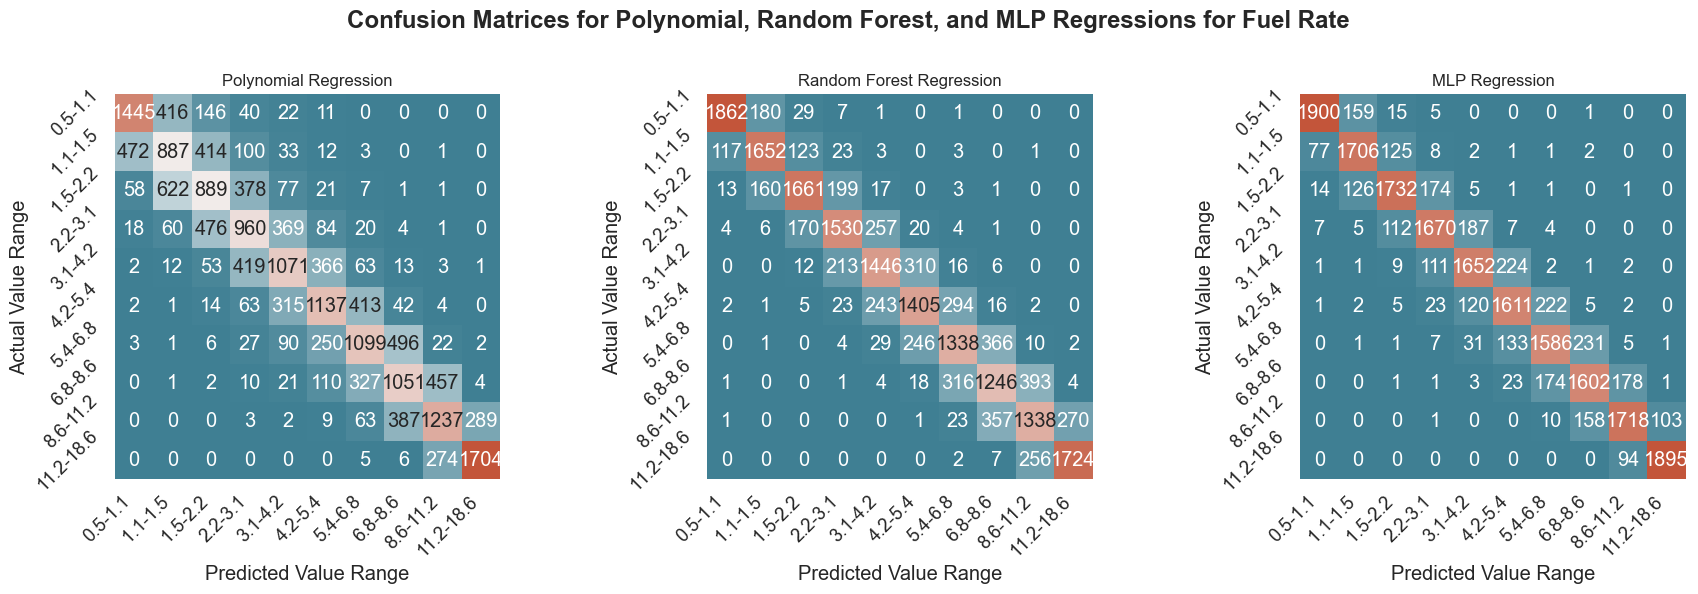

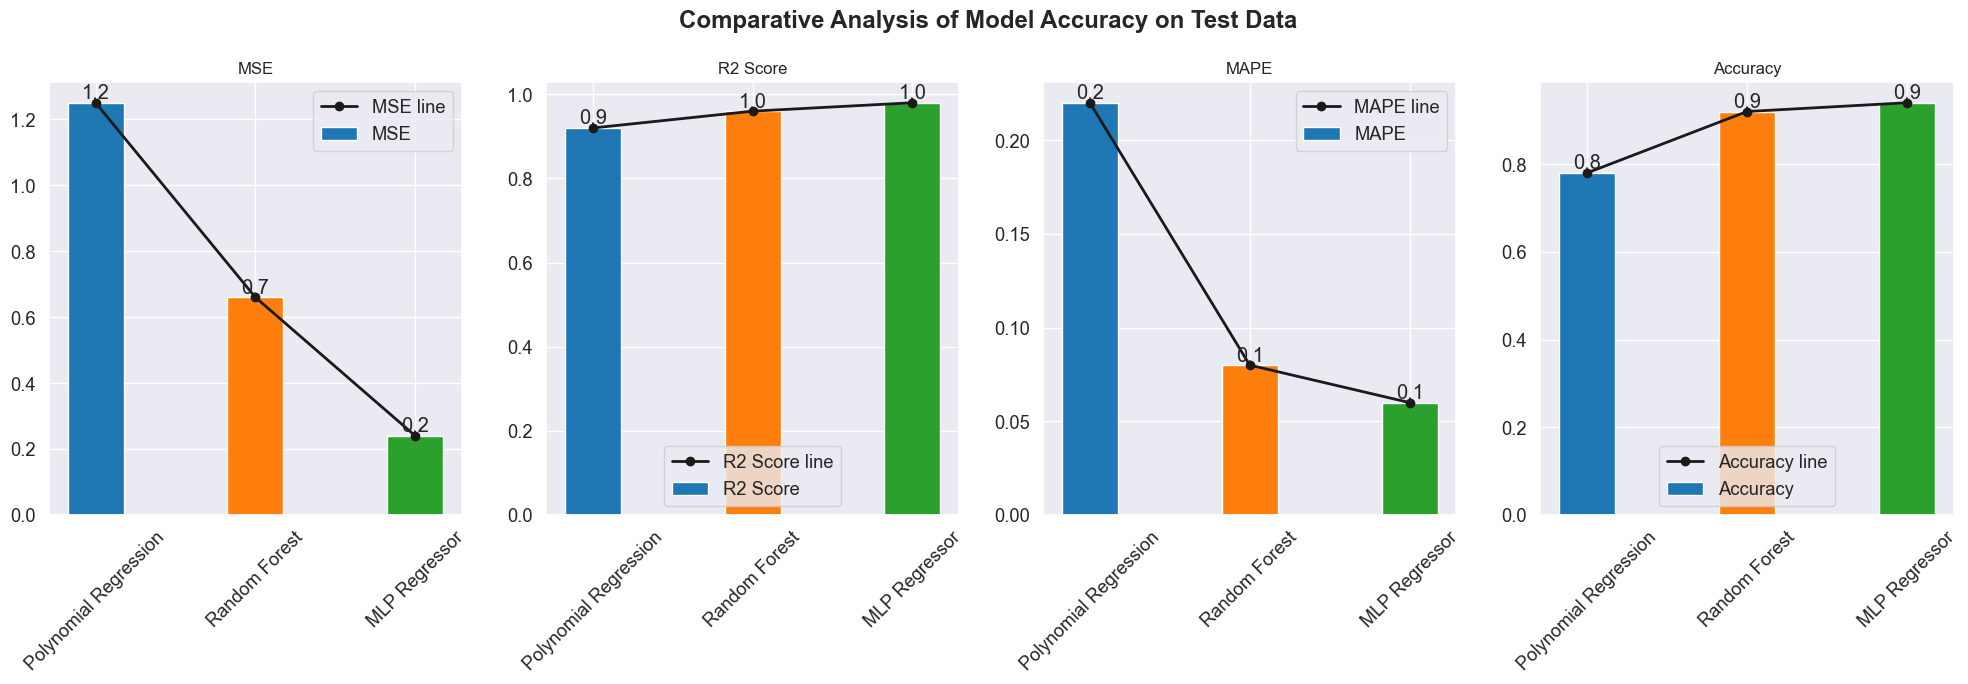

In [114]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, accuracy_score, confusion_matrix
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns


# Sample data
df_2017_sample = df_2017.sample(20000)
df_2018_sample = df_2018.sample(20000)
X_train = df_2017_sample.drop(columns=['FuelRate'])
y_train = df_2017_sample['FuelRate']
X_test = df_2018_sample.drop(columns=['FuelRate'])
y_test = df_2018_sample['FuelRate']

# Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameters
poly_hyperparams = {'degree': 1}
rf_hyperparams = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 42}
mlp_hyperparams = {'hidden_layer_sizes': (50, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42}

# Model training functions
def train_poly_regression(X_train, y_train, X_test, y_test, hyperparams):
    poly_features = PolynomialFeatures(degree=hyperparams['degree'])
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    model = LinearRegression().fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    return mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), y_pred

def train_rf_regression(X_train, y_train, X_test, y_test, hyperparams):
    model = RandomForestRegressor(**hyperparams).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), y_pred

def train_mlp_regression(X_train, y_train, X_test, y_test, hyperparams):
    model = MLPRegressor(**hyperparams).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), y_pred

# Evaluate models and compile results
evaluation_results = []
y_preds = []  # To store predictions of each model
models = []  # To store model objects for feature importance

for model_name, train_func, hyperparams in [
    ("Polynomial Regression", train_poly_regression, poly_hyperparams),
    ("Random Forest", train_rf_regression, rf_hyperparams),
    ("MLP Regressor", train_mlp_regression, mlp_hyperparams)]:
    mse, r2, mape, y_pred = train_func(X_train_scaled, y_train, X_test_scaled, y_test, hyperparams)
    evaluation_results.append({'Model': model_name, 'MSE': mse, 'R2 Score': r2, 'MAPE': mape})
    y_preds.append(y_pred)


evaluation_results_df = pd.DataFrame(evaluation_results)
evaluation_results_df['Accuracy'] = 1 - evaluation_results_df['MAPE']
evaluation_results_df = evaluation_results_df.round(2)
evaluation_results_df = evaluation_results_df[['Model', 'MSE', 'R2 Score', 'MAPE', 'Accuracy']]
print(evaluation_results_df)

# Confusion matrix for each model

nbins = 10
y_true_binned, bins = pd.qcut(y_test, q=nbins, labels=False, duplicates='drop', retbins=True)

# Prepare confusion matrices for each model
cms = []
for y_pred in y_preds:
    y_pred_binned = pd.qcut(y_pred, q=nbins, labels=False, duplicates='drop')
    cm = confusion_matrix(y_true_binned, y_pred_binned)
    cms.append(cm)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), dpi=100)
fig.suptitle('Confusion Matrices for Polynomial, Random Forest, and MLP Regressions for Fuel Rate', fontweight='bold')

cmap = sns.diverging_palette(220, 20, as_cmap=True)

titles = ['Polynomial Regression', 'Random Forest Regression', 'MLP Regression']
bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

for ax, cm, title in zip(axes.flat, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=False, square=True)
    ax.set_title(title, fontsize=12, fontfamily='Arial')
    ax.set_xlabel('Predicted Value Range')
    ax.set_ylabel('Actual Value Range')
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')
    ax.set_yticklabels(bin_labels, rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# evaluation_results_df plot
models = evaluation_results_df['Model'].values
metrics = ['MSE', 'R2 Score', 'MAPE', 'Accuracy']
index = np.arange(len(models))
bar_width = 0.35

fig, ax = plt.subplots(1, len(metrics), figsize=(20, 7))
fig.suptitle('Comparative Analysis of Model Accuracy on Test Data', fontweight='bold')

for i, metric in enumerate(metrics):
    model_scores = evaluation_results_df[metric].values
    ax[i].bar(index, model_scores, bar_width, label=metric, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

    ax[i].plot(index, model_scores, color='k', marker='o', linestyle='-', linewidth=2, markersize=6, label=f'{metric} line')

    for j, value in enumerate(model_scores):
        ax[i].text(index[j], value, f'{value:.1f}', ha='center', va='bottom')

    ax[i].set_title(metric, fontsize=12, fontfamily='Arial')
    ax[i].set_xticks(index)
    ax[i].set_xticklabels(models, rotation=45)
    ax[i].legend()

plt.tight_layout()

plt.show()

The confusion matrices for the polynomial regression, random forest, and MLP regression models provide valuable insights into their predictive capabilities across various fuel rate variable value ranges. These matrices act as a dual-purpose tool, offering both a graphical and numerical means to assess the efficacy of each regression model. Confusion matrices are traditionally utilized in classification contexts; their adaptation for regression problems facilitates an intuitive visualization of the discrepancies between actual and predicted values. By discretizing the continuous output into predefined intervals, we leverage these matrices to segment and scrutinize the performance of the models methodically. This innovative approach allows for a nuanced evaluation, enabling a clearer understanding of how well each model predicts across different segments of the Fuel Rate variable.
The Polynomial Regression matrix has a fair distribution of correct predictions (diagonal elements), although misclassifications are evident, particularly in intermediate value ranges. The Random Forest model's confusion matrix displays a more distinct diagonal, indicating a higher rate of accurate predictions, with some notable confusion at the extreme value ranges. The MLP Regressor's matrix shows an even stronger diagonal, signifying a superior rate of correct predictions, especially for lower values, with relatively fewer inaccuracies than the other models. This analysis suggests that the MLP Regressor slightly outperforms the other models regarding prediction accuracy across different value ranges.


# Sensitivy Analysis

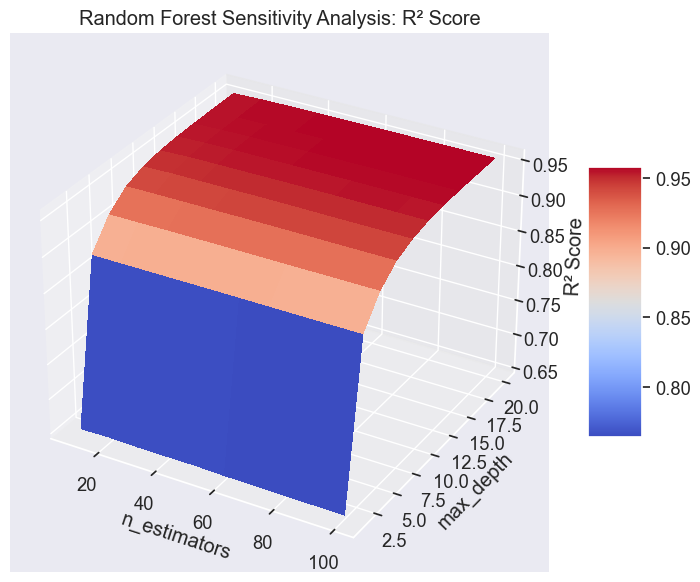

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler

# df_2017_sample and df_2018_sample are preloaded
df_2017_sample = df_2017.sample(100)
df_2018_sample = df_2018.sample(100)

# Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter ranges for the sensitivity analysis
n_estimators_range = np.linspace(10, 100, 10, dtype=int)  # More points for a smoother surface
max_depth_range = np.linspace(1, 20, 10, dtype=int)       # Convert None to a range, e.g., 1 to 20

# Fixed min_samples_split for simplification
min_samples_split_fixed = 2

# Meshgrid for parameters
n_estimators_mesh, max_depth_mesh = np.meshgrid(n_estimators_range, max_depth_range)

# Initialize result grid
score_grid = np.zeros(n_estimators_mesh.shape)

# Perform the sensitivity analysis
for i in range(n_estimators_mesh.shape[0]):
    for j in range(n_estimators_mesh.shape[1]):
        n_estimators = n_estimators_mesh[i, j]
        max_depth = max_depth_mesh[i, j]
        
        # Configure the model
        rf_hyperparams = {
            'n_estimators': int(n_estimators),
            'max_depth': int(max_depth),
            'min_samples_split': min_samples_split_fixed,
            'min_samples_leaf': 1,
            'random_state': 42
        }
        
        # Train and evaluate the model
        model = RandomForestRegressor(**rf_hyperparams).fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        score = r2_score(y_test, y_pred)
        
        # Store the result
        score_grid[i, j] = score

# Visualization with a 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(n_estimators_mesh, max_depth_mesh, score_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Labels and title
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('R² Score')
plt.title('Random Forest Sensitivity Analysis: R² Score')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


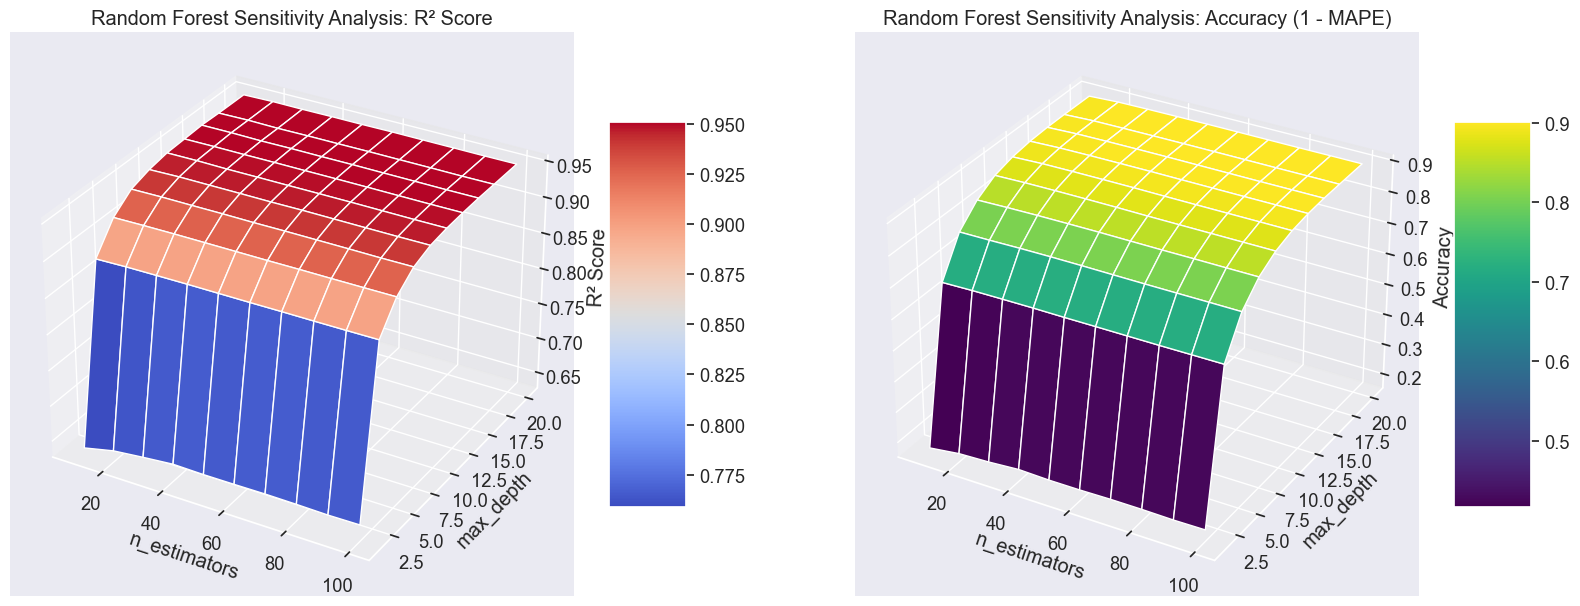

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#  df_2017_sample and df_2018_sample are your datasets
df_2017_sample = df_2017.sample(10000)
df_2018_sample = df_2018.sample(10000)
# Preprocess the data
X_train = df_2017_sample.drop(columns=['FuelRate'])
y_train = df_2017_sample['FuelRate']
X_test = df_2018_sample.drop(columns=['FuelRate'])
y_test = df_2018_sample['FuelRate']

# Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter ranges for the sensitivity analysis
n_estimators_range = np.linspace(10, 100, 10, dtype=int)  # More points for a smoother surface
max_depth_range = np.linspace(1, 20, 10, dtype=int)       # Convert None to a range, e.g., 1 to 20

# Fixed min_samples_split for simplification
min_samples_split_fixed = 2

# Meshgrid for parameters
n_estimators_mesh, max_depth_mesh = np.meshgrid(n_estimators_range, max_depth_range)

# Initialize result grids
r2_score_grid = np.zeros(n_estimators_mesh.shape)
accuracy_grid = np.zeros(n_estimators_mesh.shape)  # For 1 - MAPE

# Perform the sensitivity analysis
for i in range(n_estimators_mesh.shape[0]):
    for j in range(n_estimators_mesh.shape[1]):
        n_estimators = n_estimators_mesh[i, j]
        max_depth = max_depth_mesh[i, j]
        
        # Configure the model
        rf_hyperparams = {
            'n_estimators': int(n_estimators),
            'max_depth': int(max_depth),
            'min_samples_split': min_samples_split_fixed,
            'min_samples_leaf': 1,
            'random_state': 42
        }
        
        # Train and evaluate the model
        model = RandomForestRegressor(**rf_hyperparams).fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        # Store the results
        r2_score_grid[i, j] = r2
        accuracy_grid[i, j] = 1 - mape  # Calculating accuracy as 1 - MAPE

# Visualization with 3D surface plots
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(20, 10))

# Plot for R² Score
surf_r2 = axes[0].plot_surface(n_estimators_mesh, max_depth_mesh, r2_score_grid, cmap=cm.coolwarm)
axes[0].set_title('Random Forest Sensitivity Analysis: R² Score')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('max_depth')
axes[0].set_zlabel('R² Score')
fig.colorbar(surf_r2, ax=axes[0], shrink=0.5, aspect=5)

# Plot for Accuracy (1 - MAPE)
surf_acc = axes[1].plot_surface(n_estimators_mesh, max_depth_mesh, accuracy_grid, cmap=cm.viridis)
axes[1].set_title('Random Forest Sensitivity Analysis: Accuracy (1 - MAPE)')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('max_depth')
axes[1].set_zlabel('Accuracy')
fig.colorbar(surf_acc, ax=axes[1], shrink=0.5, aspect=5)

plt.show()


A comprehensive sensitivity analysis was conducted on a Random Forest model to evaluate the impact of two key hyperparameters: the number of estimators (n_estimators) and the maximum depth of the trees (max_depth). The analysis utilized two performance metrics: the R² score and the model accuracy (1 - MAPE). Surface plots were generated to visualize the dependency of model performance on the hyperparameter values.   The results are presented in two 3D surface plots. The first plot correlates the R² score with varying n_estimators and max_depth, revealing a positive relationship between these parameters and the R² score. A higher number of estimators and greater tree depth correspond to improved R² scores, suggesting a better fit of the model to the data.

The second plot examines the model accuracy, defined as 1 minus the Mean Absolute Percentage Error (MAPE). Similar to the R² score, a positive correlation is observed where increases in both n_estimators and max_depth are associated with higher accuracy levels.  The sensitivity analysis indicates that for this dataset, a Random Forest model's predictive power improves with an increase in the number of estimators and the depth of the trees. This trend is consistent across both evaluation metrics used. These insights can be leveraged for hyperparameter tuning to enhance model performance.

# MLP Sensitiviy

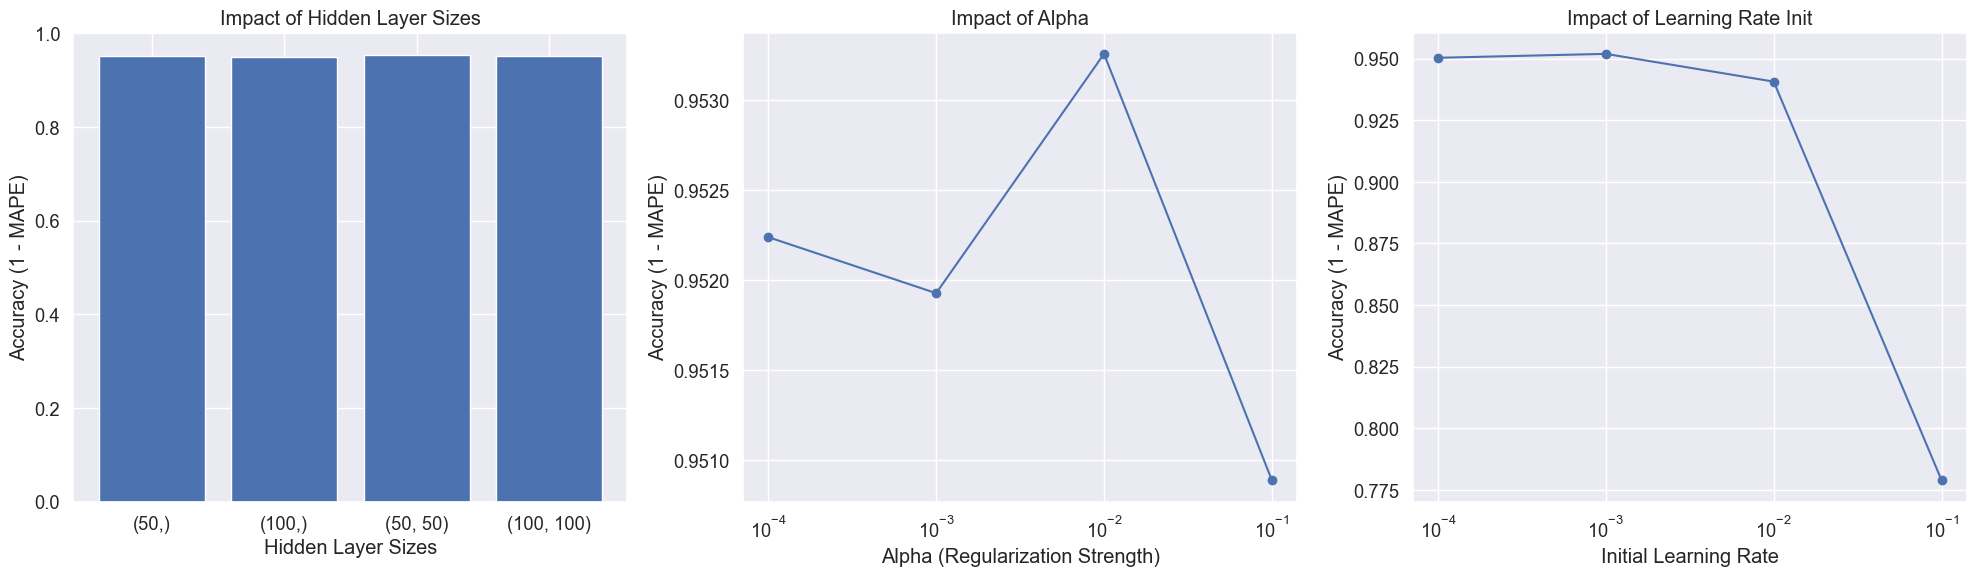

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# df_2017 and df_2018 are predefined dataframes
df_2017_sample = df_2017.sample(1000)
df_2018_sample = df_2018.sample(1000)
# Sample preprocessing steps (replace these with your actual preprocessing)
X_train = df_2017.drop(columns=['FuelRate'])
y_train = df_2017['FuelRate']
X_test = df_2018.drop(columns=['FuelRate'])
y_test = df_2018['FuelRate']

# Scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter ranges
hidden_layer_sizes_range = [(50,), (100,), (50, 50), (100, 100)]
alpha_range = np.logspace(-4, -1, 4)
learning_rate_init_range = np.logspace(-4, -1, 4)

# Initialize dictionaries to store accuracy results
accuracy_by_hidden_layer = {}
accuracy_by_alpha = {}
accuracy_by_learning_rate = {}

# Representative values for fixed parameters
hidden_layer_sizes_fixed = (50, 50)
alpha_fixed = 0.001
learning_rate_init_fixed = 0.001

# Sensitivity analysis for hidden_layer_sizes
for hidden_layer_sizes in hidden_layer_sizes_range:
    mlp_hyperparams = {
        'hidden_layer_sizes': hidden_layer_sizes,
        'activation': 'tanh',
        'solver': 'adam',
        'alpha': alpha_fixed,
        'learning_rate_init': learning_rate_init_fixed,
        'max_iter': 1000,
        'random_state': 42
    }
    model = MLPRegressor(**mlp_hyperparams).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy_by_hidden_layer[str(hidden_layer_sizes)] = 1 - mape

# Sensitivity analysis for alpha
for alpha in alpha_range:
    mlp_hyperparams['alpha'] = alpha
    model = MLPRegressor(**mlp_hyperparams).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy_by_alpha[alpha] = 1 - mape

# Reset alpha to fixed value and analyze learning_rate_init
mlp_hyperparams['alpha'] = alpha_fixed
for learning_rate_init in learning_rate_init_range:
    mlp_hyperparams['learning_rate_init'] = learning_rate_init
    model = MLPRegressor(**mlp_hyperparams).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy_by_learning_rate[learning_rate_init] = 1 - mape

# Visualization
plt.figure(figsize=(20, 6))

# Hidden Layer Sizes
plt.subplot(1, 3, 1)
plt.bar(range(len(accuracy_by_hidden_layer)), list(accuracy_by_hidden_layer.values()), align='center')
plt.xticks(range(len(accuracy_by_hidden_layer)), list(accuracy_by_hidden_layer.keys()))
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy (1 - MAPE)')
plt.title('Impact of Hidden Layer Sizes')

# Alpha
plt.subplot(1, 3, 2)
plt.semilogx(list(accuracy_by_alpha.keys()), list(accuracy_by_alpha.values()), marker='o')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Accuracy (1 - MAPE)')
plt.title('Impact of Alpha')

# Learning Rate Init
plt.subplot(1, 3, 3)
plt.semilogx(list(accuracy_by_learning_rate.keys()), list(accuracy_by_learning_rate.values()), marker='o')
plt.xlabel('Initial Learning Rate')
plt.ylabel('Accuracy (1 - MAPE)')
plt.title('Impact of Learning Rate Init')

plt.tight_layout()
plt.show()

The sensitivity analysis of the Multilayer Perceptron Regressor indicated that model accuracy, inversely related to the Mean Absolute Percentage Error (MAPE), was largely unaffected by variations in hidden layer sizes within the tested range, suggesting a plateau in performance gains from this parameter. However, the regularization strength (alpha) and initial learning rate demonstrated a more pronounced effect on performance, with optimal values yielding the highest accuracy, indicating that these parameters are crucial for tuning. Future work should focus on a broader and more interactive hyperparameter search, including advanced optimization techniques like Bayesian optimization, to potentially uncover more effective model configurations and improve the predictiveness of the model.

# Outliers

In [61]:
X_train.shape

(100, 23)

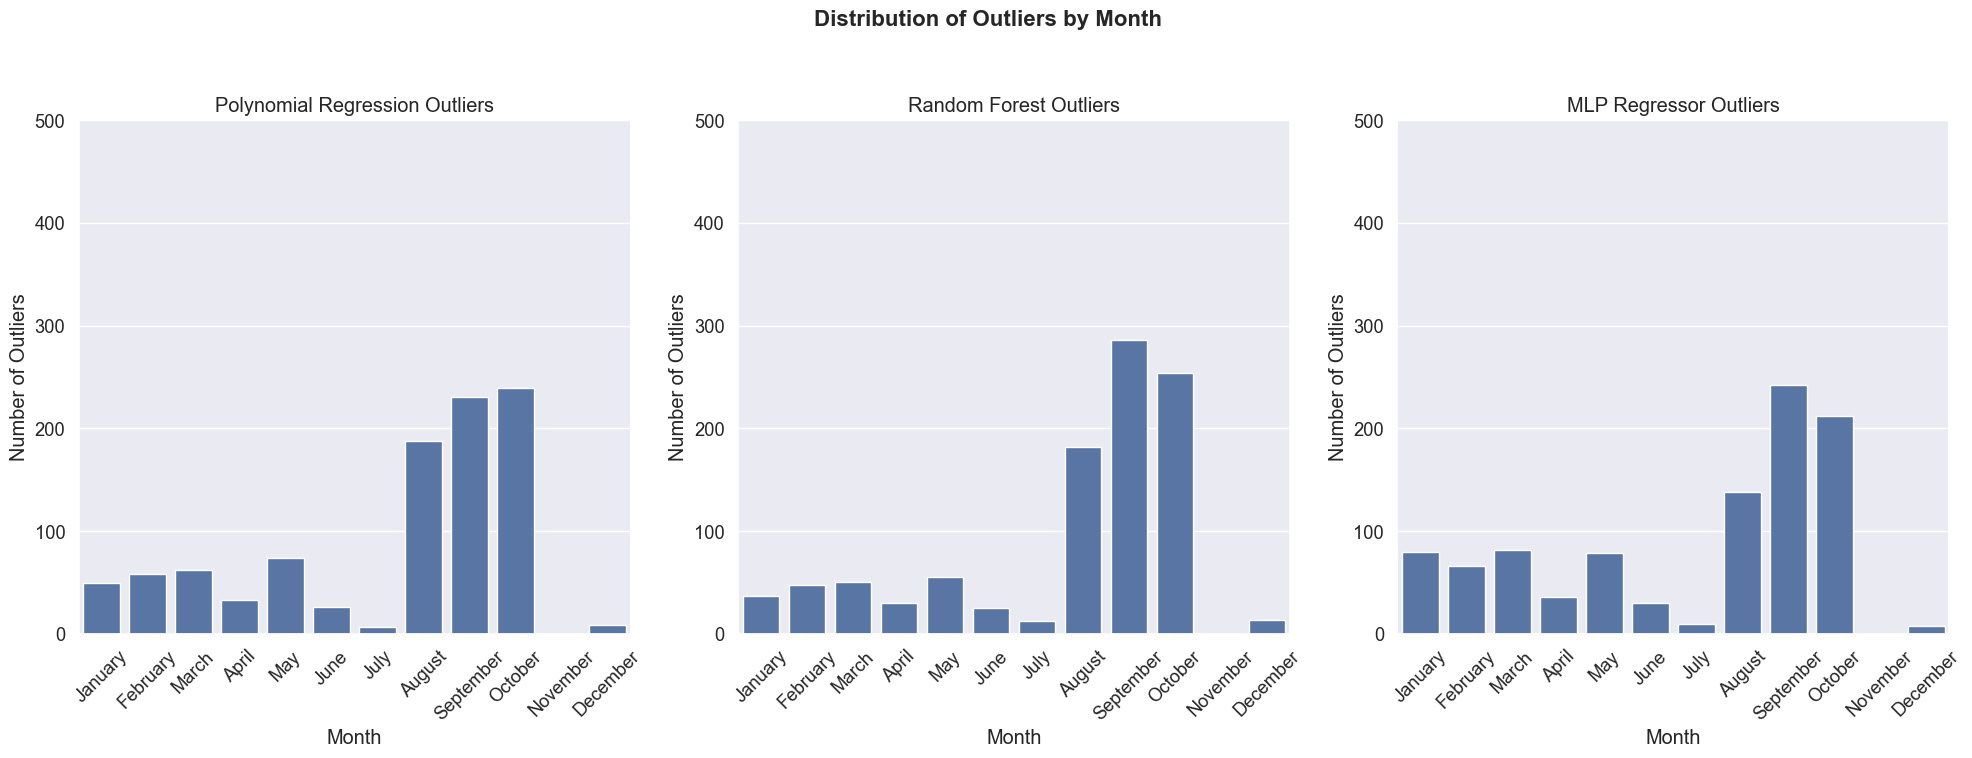

In [151]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


df_2017_sample = df_2017.sample(10000)
df_2018_sample = df_2018.sample(10000)

X_train = df_2017_sample.drop(columns=['FuelRate'])
y_train = df_2017_sample['FuelRate']
X_test = df_2018.drop(columns=['FuelRate'])
y_test = df_2018['FuelRate']



# Prepare and scale the data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize lists for storing models and their predictions
trained_models = []
evaluation_results = []
y_preds = []

# Define and train models
models = [
    ("Polynomial Regression", PolynomialFeatures(degree=1), LinearRegression()),
    ("Random Forest", None, RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)),
    ("MLP Regressor", None, MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', alpha=0.0001, learning_rate='constant', max_iter=1000, random_state=42))
]

for model_name, transformer, model in models:
    if transformer:
        X_train_transformed = transformer.fit_transform(X_train_scaled)
        X_test_transformed = transformer.transform(X_test_scaled)
    else:
        X_train_transformed, X_test_transformed = X_train_scaled, X_test_scaled

    # Train model
    trained_model = model.fit(X_train_transformed, y_train)
    trained_models.append(trained_model)
    

    # Predict and evaluate
    y_pred = trained_model.predict(X_test_transformed)
    y_preds.append(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    evaluation_results.append({'Model': model_name, 'MSE': mse, 'R2 Score': r2, 'MAPE': mape})

# Outlier detection and annotation
for i, (model_name, _, _) in enumerate(models):
    y_pred = y_preds[i]
    absolute_residuals = np.abs(y_test - y_pred)
    threshold = np.percentile(absolute_residuals, 90)
    outliers = absolute_residuals > threshold
    df_2018_sample[model_name + ' Outliers'] = outliers  # Annotate DataFrame with outliers

# Plotting the distribution of outliers for each model
#set the font size to 12
sns.set(font_scale=1.2)
plt.figure(figsize=(20, 8))
#create outlers data frame
outliers_df = pd.DataFrame()
#use outler datafram same as df_2018_sample with the same index
outliers_df = df_2018_sample.copy()



for i, model_name in enumerate([model[0] for model in models]):
    plt.subplot(1, 3, i + 1)
    # Since we're plotting outliers, we need a count of outliers by month, ensuring the index is datetime
    outlier_counts = outliers_df[outliers_df[model_name + ' Outliers']].resample('M').size()
    sns.barplot(x=outlier_counts.index.month_name(), y=outlier_counts.values, color='b')
    #change font siz
    plt.title(f'{model_name} Outliers')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Outliers')
    plt.ylim(0, 500)


plt.suptitle('Distribution of Outliers by Month', fontsize=16, fontweight='bold')
# fix all the y axis to be the same
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


The analysis of outlier distribution across different regression models reveals distinct patterns of anomaly detection throughout the year. Polynomial Regression tends to identify a higher number of outliers towards the end of the year, with a pronounced peak closer to October. Random Forest exhibits its greatest sensitivity to outliers in the fall months, particularly in October, while the MLP Regressor shows a progressive increase in outlier detection culminating in October. These patterns coincide with the actual injector failure in October 2018

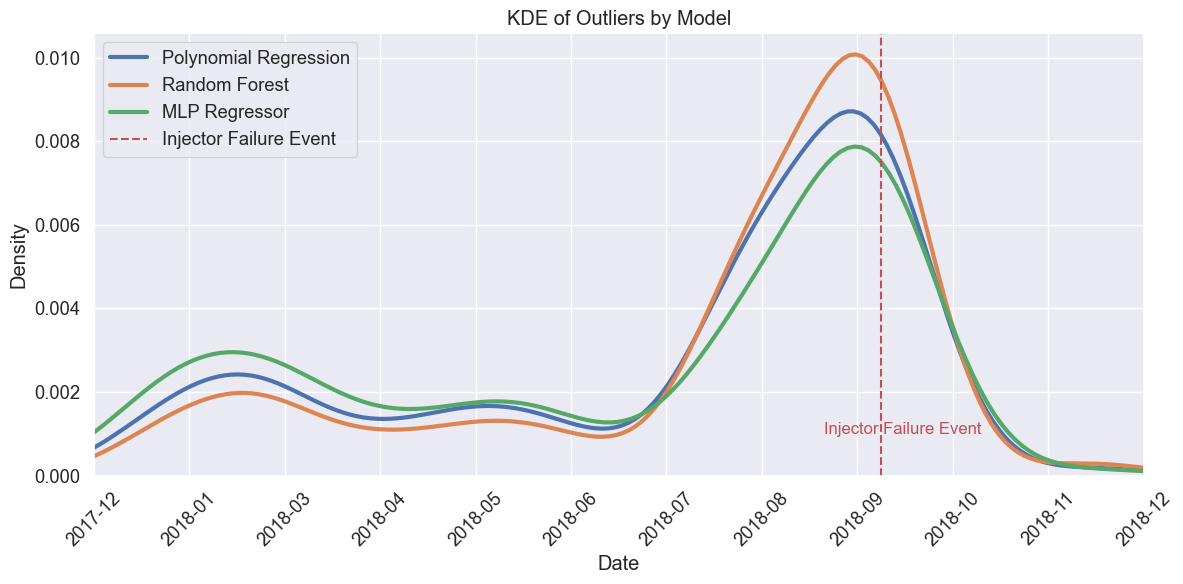

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12, 6))

# Assuming outliers_df is your DataFrame and it's indexed by datetime
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2018-12-31')
event_date = pd.to_datetime('2018-10-01')  # Date of the Injector Failure Event

# Plot KDE for each model's outliers on the same plot
for model_name in [model[0] for model in models]:
    outlier_dates = outliers_df.index[outliers_df[model_name + ' Outliers']]
    days_since_start = (outlier_dates - outliers_df.index.min()).days

    # Plot KDE
    sns.kdeplot(days_since_start, label=model_name, fill=False, linewidth=3)

# Calculate the x positions for the start, end, and event in 'days since start'
start_days = (start_date - outliers_df.index.min()).days
end_days = (end_date - outliers_df.index.min()).days
event_days = (event_date - outliers_df.index.min()).days

# Set the x-axis limits to show only January to December 2018
plt.xlim(start_days, end_days)

# Add a vertical line for the Injector Failure Event
plt.axvline(event_days, color='r', linestyle='--', label='Injector Failure Event')
#Add a note to the event
plt.text(event_days-20, 0.001, 'Injector Failure Event', color='r', rotation=0)

# Update the x-ticks to represent dates within the specified range
xticks = np.linspace(start_days, end_days, 12)  # Roughly one tick per month
new_labels = [start_date + pd.Timedelta(days=int(x)) for x in xticks]
plt.xticks(ticks=xticks, labels=[label.strftime('%Y-%m') for label in new_labels], rotation=45)

plt.title('KDE of Outliers by Model')
plt.xlabel('Date')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


Upon evaluating the KDE of outliers, as identified by three predictive models, it is evident that all models can detect the increased outlier density associated with the Injector Failure Event. The MLP Regressor demonstrates a marginally higher sensitivity, reflected by a slightly higher peak density. Furthermore, the broader peak of the Random Forest model suggests a more comprehensive range of data points identified as outliers, potentially offering a more comprehensive detection of anomalous behavior leading up to the failure event. 

# Unsupervised

In [24]:
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.covariance import MinCovDet

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

Index(['AccelPedalPos', 'BoostPres', 'EngCoolantTemp', 'EngDesiredOpSpd',
       'EngDmdPctTorq', 'EngOilPres', 'EngPctLdAtCurSpd', 'EngPctTorq',
       'EngSpeed', 'FuelRate', 'InjCtlPres', 'InpSftSp', 'InstFuelEco',
       'IntManfTemp', 'PctEngLoad', 'TransOilTemp',
       'TransOptShaftSpeedTrans_1587', 'VehSpeedEng'],
      dtype='object')

# Data Engineering Unsupervised

In [3]:
import pandas as pd
from sklearn.decomposition import PCA
#import RobustScaler from sklearn.preprocessing
from sklearn.preprocessing import RobustScaler
#read df_2018.parquet file
df_2018 = pd.read_parquet('df_2018.parquet')

df_2018_unsupervised = df_2018.copy()
#drop all the data that are categorical nature
df_2018_unsupervised = df_2018_unsupervised.drop(columns=['TranActGearRato','TransCurGear', 'TransDrivEng','TransTorqConvLockupEngaged', 'TrRgAttai', 'TrSelGr'])
df_2018_unsupervised
# scale the data
scaler = RobustScaler()
df_2018_unsupervised_scaled = scaler.fit_transform(df_2018_unsupervised)
#convert the data to a dataframe
df_2018_unsupervised_scaled = pd.DataFrame(df_2018_unsupervised_scaled, columns=df_2018_unsupervised.columns)
#add index to the dataframe
df_2018_unsupervised_scaled.index = df_2018_unsupervised.index



# Assuming df_2018_unsupervised_scaled is already defined
pca = PCA(n_components=5)
df_2018_unsupervised_scaled_pca_array = pca.fit_transform(df_2018_unsupervised_scaled)

# Directly creating the DataFrame with columns and index
df_2018_unsupervised_scaled_pca = pd.DataFrame(
    df_2018_unsupervised_scaled_pca_array, 
    columns=[f'PC{i+1}' for i in range(5)],
    index=df_2018_unsupervised_scaled.index
)


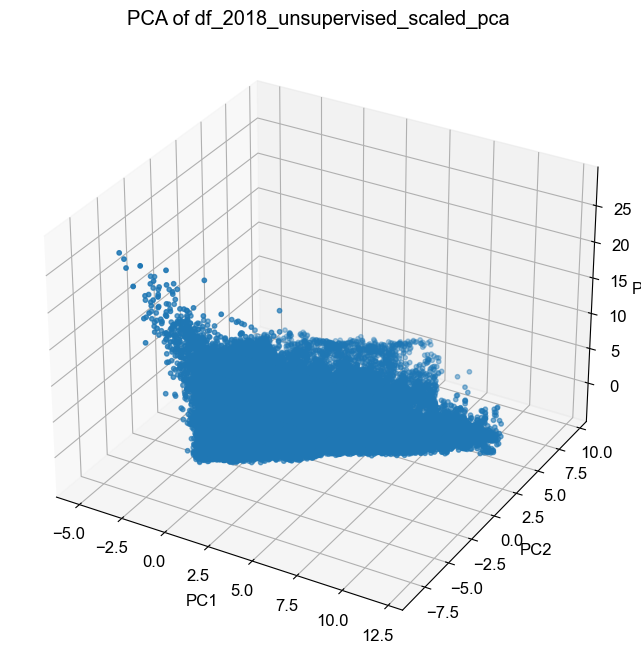

In [111]:
#plot PCA 1,2,3 in a 3D plot for df_2018_unsupervised_scaled_pca
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(df_2018_unsupervised_scaled_pca['PC1'], df_2018_unsupervised_scaled_pca['PC2'], df_2018_unsupervised_scaled_pca['PC3'], s=10)

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('PCA of df_2018_unsupervised_scaled_pca')
plt.show()

# Provide PCA ratio of explained variance
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cumulative = explained_variance_ratio.cumsum()
explained_variance_ratio_cumulative

# Plot the cumulative explained variance
plt.figure(figsize=(6, 3))
# plt.bar(range(1, 6), explained_variance_ratio_cumulative, marker='o', linestyle='--')
#need a bar plot
plt.bar(range(1, 6), explained_variance_ratio, label='Explained Variance by Principal Component')
#add the cumulative explained variance
plt.plot(range(1, 6), explained_variance_ratio_cumulative, marker='o', linestyle='--', color='r', label='Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, 6))
plt.grid(True)


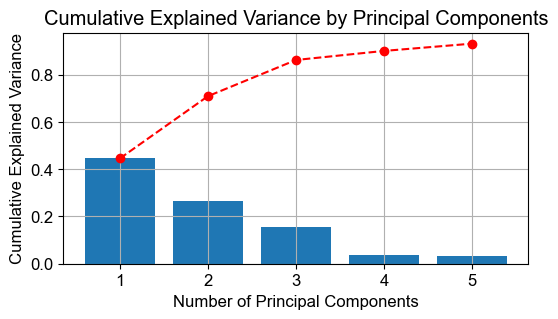

Plot shows that we need 5 of more principal components to capture variance of the data.  

In [118]:

df_channel_name_selected_table_unsupervised  = df_channel_name_selected[df_channel_name_selected['Keyword'].isin(df_2018_unsupervised.columns)]
df_channel_name_selected_table_unsupervised = df_channel_name_selected_table_unsupervised.reset_index(drop=True) 
#write this to a csv file
#df_channel_name_selected_table_unsupervised.to_csv('df_channel_name_selected_table_unsupervised.csv', index=False)
df_channel_name_selected_table_unsupervised


Keyword                              channel_name  \
0                  AccelPedalPos               Accelerator Pedal Position    
1                      BoostPres     Boost Pressure from Intake Manifold     
2                 EngCoolantTemp               Engine Coolant Temperature    
3                EngDesiredOpSpd         Engine s Desired Operating Speed    
4                  EngDmdPctTorq           Engine Demand - Percent Torque    
5                     EngOilPres                      Engine Oil Pressure    
6               EngPctLdAtCurSpd     Engine Percent Load At Current Speed    
7                     EngPctTorq   Drivers Demand Engine - Percent Torque    
8                       EngSpeed                             Engine Speed    
9                       FuelRate                                Fuel Rate    
10                    InjCtlPres               Injection Control Pressure    
11                      InpSftSp                        Input Shaft Speed    
12                   InstFuelEco               Instantaneous Fuel Economy    
13                   IntManfTemp              Intake Manifold Temperature    
14                    PctEngLoad            Actual Engine- Percent Torque    
15                  TransOilTemp             Transmission Oil Temperature    
16  TransOptShaftSpeedTrans_1587          Transmission Output Shaft Speed    
17                   VehSpeedEng                            Vehicle Speed    

   Measurement_Unit  
0                 %  
1               psi  
2                 F  
3               RPM  
4                 %  
5               psi  
6                 %  
7                 %  
8               RPM  
9        gallons/hr  
10              psi  
11              RPM  
12       gallons/hr  
13                F  
14                %  
15                F  
16              RPM  
17       miles/hour

Number of outliers detected (n_estimators=50): 6141
Number of outliers detected (n_estimators=100): 6141
Number of outliers detected (n_estimators=150): 6141
Number of outliers detected (n_estimators=200): 6141


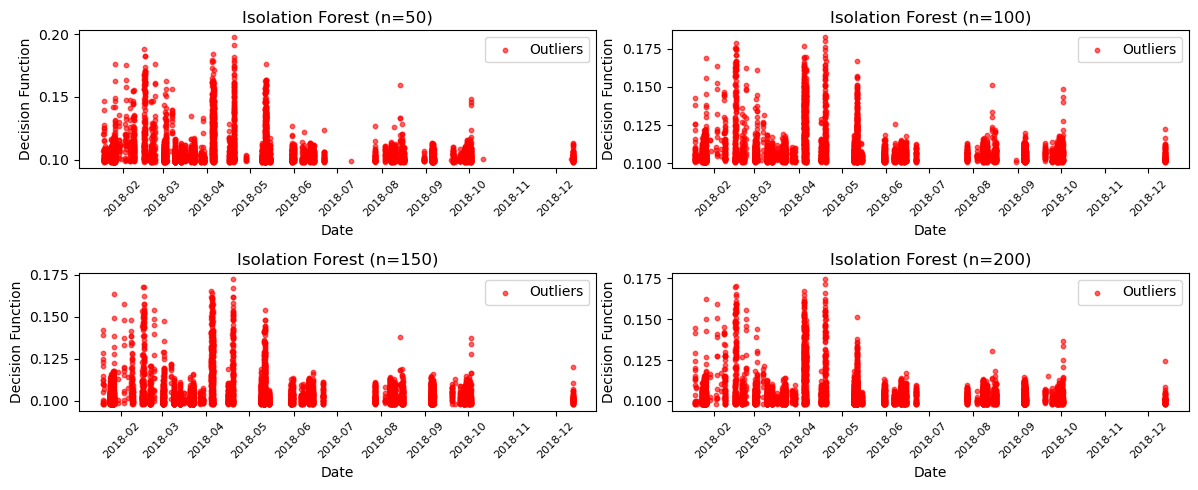

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_2018 is your DataFrame and is already loaded

# Copy df_2018 for unsupervised learning
X_train_unsupervised = df_2018_unsupervised.copy()

# Scale the data
scaler = RobustScaler()
X_train_unsupervised_scaled = pd.DataFrame(scaler.fit_transform(X_train_unsupervised), 
                                           index=X_train_unsupervised.index, 
                                           columns=X_train_unsupervised.columns)

def detect_outliers_with_isolation_forest(df, n_estimators):
    model = IsolationForest(n_estimators=n_estimators, contamination='auto', random_state=42)
    model.fit(df)

    decision_function = abs(model.decision_function(df))
    threshold = np.percentile(decision_function, 95)
    
    outliers = decision_function > threshold
    print(f"Number of outliers detected (n_estimators={n_estimators}): {np.sum(outliers)}")
    
    return decision_function, outliers, threshold

n_estimators_list = [50, 100, 150, 200]
fig, axs = plt.subplots(2, 2, figsize=(12, 5))  # 2x2 matrix of plots

for i, n_estimators in enumerate(n_estimators_list):
    row = i // 2
    col = i % 2
    decision_function, outliers, _ = detect_outliers_with_isolation_forest(X_train_unsupervised_scaled, n_estimators)
    
    axs[row, col].scatter(X_train_unsupervised_scaled.index[outliers], decision_function[outliers], 
                          c='r', label='Outliers', alpha=0.6, s=10)
    axs[row, col].set_title(f'Isolation Forest (n={n_estimators})')
    
    axs[row, col].tick_params(axis='x', rotation=45, labelsize=8)  # Rotate for readability
    
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Decision Function', fontsize=10)
    axs[row, col].legend()

plt.tight_layout()
plt.show()


This plot provides a comparative analysis of the Isolation Forest algorithm's performance with varying parameter settings—specifically, the number of estimators (denoted by 'n').   The estimators of 'n' values range from 50 to 200, allowing us to observe the impact of this parameter on the detection of outliers. The Y-axis, labeled 'Decision Function,' indicates the anomaly score for each data point.  In all charts, the points that are further away from the main data cluster—and hence have a higher score—are considered outliers, as indicated by the label on the charts. By examining the distribution of these scores across different parameter settings, we could not infer the sensitivity of the Isolation Forest algorithm with varying 'n' values, thus suggesting that the number of estimators is insensitive to this specific data set.  

Number of outliers detected (n_estimators=100): 6141


array([False, False, False, ..., False, False, False])

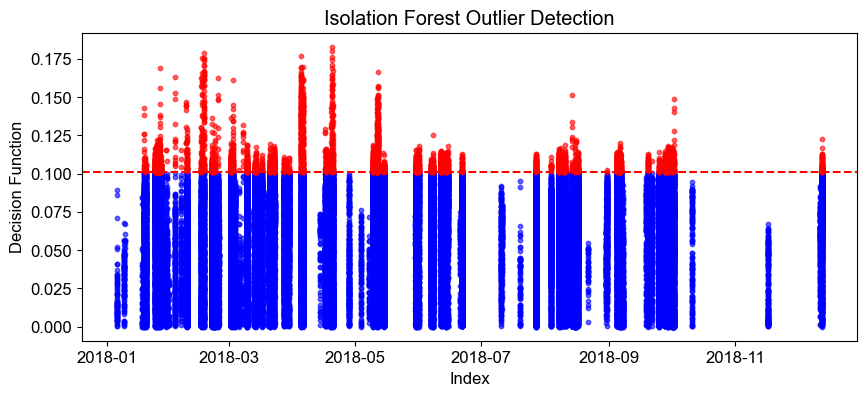

In [68]:
# Assuming X_train_unsupervised_scaled is defined and n_estimators is set
decision_function, outliers, threshold = detect_outliers_with_isolation_forest(X_train_unsupervised_scaled, 100)

plt.figure(figsize=(10,4))
# Plot inliers
plt.scatter(X_train_unsupervised_scaled.index[~outliers], decision_function[~outliers], c='blue', label='Inliers', alpha=0.6, s=10)
# Overlay outliers
plt.scatter(X_train_unsupervised_scaled.index[outliers], decision_function[outliers], c='red', label='Outliers', alpha=0.6, s=10)

# Add a line for the threshold
plt.axhline(y=threshold, color='r', linestyle='--', label='95% Threshold')

plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Decision Function')


outliers_isolation_forest = decision_function > threshold




Number of outliers detected: 11595
best_n_clusters: 2
best_silhouette_score: 0.4371729133143773


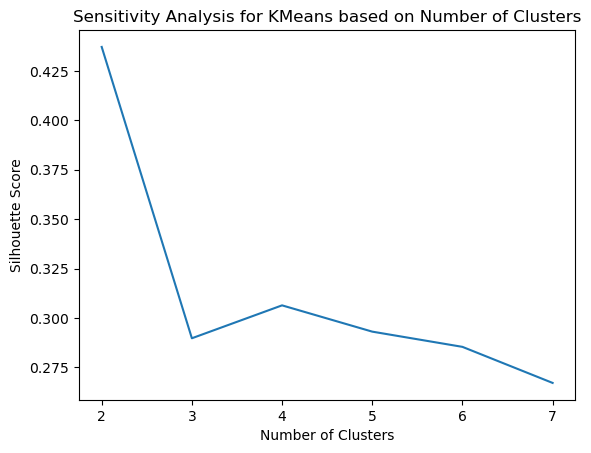

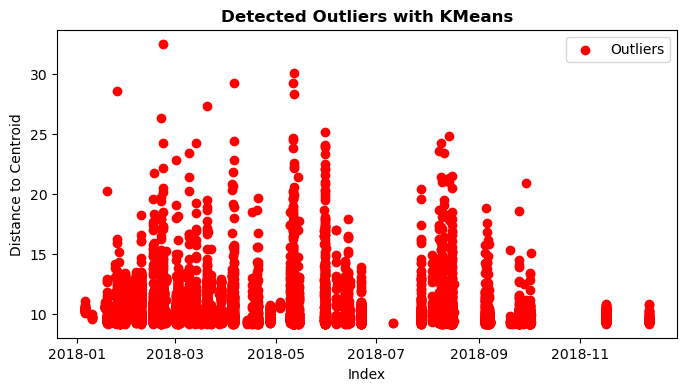

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from joblib import Parallel, delayed

# Assuming df_2018_unsupervised is predefined
X_train_unsupervised = df_2018_unsupervised.copy()

# Scale the data
def scale_data(df):
    """Scales the data using RobustScaler and returns the scaled DataFrame."""
    scaler = RobustScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return scaled_df

X_train_unsupervised_scaled = scale_data(X_train_unsupervised)

def compute_silhouette_score(df, n_clusters):
    """Computes KMeans clustering and silhouette score for a given number of clusters."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df)
    score = silhouette_score(df, kmeans.labels_)
    return score, kmeans

def detect_outliers_with_kmeans_parallel(df):
    """Detects outliers in parallel using KMeans and silhouette scores."""
    n_clusters_range = range(2, 8)
    results = Parallel(n_jobs=-1)(delayed(compute_silhouette_score)(df, i) for i in n_clusters_range)
    
    silhouette_scores, kmeans_models = zip(*results)
    best_score_index = np.argmax(silhouette_scores)
    
    # Extracting best results based on silhouette scores
    best_kmeans = kmeans_models[best_score_index]
    best_n_clusters = n_clusters_range[best_score_index]
    
    # Identifying outliers using the distance to the centroids
    centroid_distances = best_kmeans.transform(df)
    threshold = np.percentile(centroid_distances, 95)
    outliers = centroid_distances.max(axis=1) > threshold
    
    print_outliers_info(outliers, best_n_clusters, silhouette_scores[best_score_index])
    plot_silhouette_scores(n_clusters_range, silhouette_scores)
    
    return centroid_distances, outliers

def print_outliers_info(outliers, best_n_clusters, best_silhouette_score):
    """Prints information about detected outliers."""
    num_outliers = np.sum(outliers)
    print(f"Number of outliers detected: {num_outliers}")
    print(f"best_n_clusters: {best_n_clusters}")
    print(f"best_silhouette_score: {best_silhouette_score}")

def plot_silhouette_scores(n_clusters_range, silhouette_scores):
    """Plots silhouette scores for each number of clusters."""
    plt.plot(n_clusters_range, silhouette_scores)
    plt.title('Sensitivity Analysis for KMeans based on Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

# Main Execution
kmeans_function = detect_outliers_with_kmeans_parallel(X_train_unsupervised_scaled)

# Plotting outliers (assuming unsupervised_df_scaled is a typo for X_train_unsupervised_scaled)
def plot_outliers(centroid_distances, outliers):
    plt.figure(figsize=(8, 4))
    plt.scatter(X_train_unsupervised_scaled.index[outliers], centroid_distances.max(axis=1)[outliers], 
                c='red', label='Outliers')
    plt.xlabel('Index')
    plt.ylabel('Distance to Centroid')
    plt.title('Detected Outliers with KMeans', fontweight='bold')
    plt.legend()
    plt.show()

plot_outliers(*kmeans_function[:2])


The  line illustrates the silhouette scores for cluster quantities ranging from 2 to 7. As the graph demonstrates, there is a discernible downward trend in silhouette scores concurrent with an increase in the number of clusters. This observation suggests that incrementing the number of clusters does not correlate with improved cluster definition for this dataset. This sensitivity analysis highlights a reduction in silhouette scores as cluster numbers grow, indicating that a smaller number of clusters captures the structure of the data.  

c:\Users\ggugaratshan\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of outliers detected: 6141


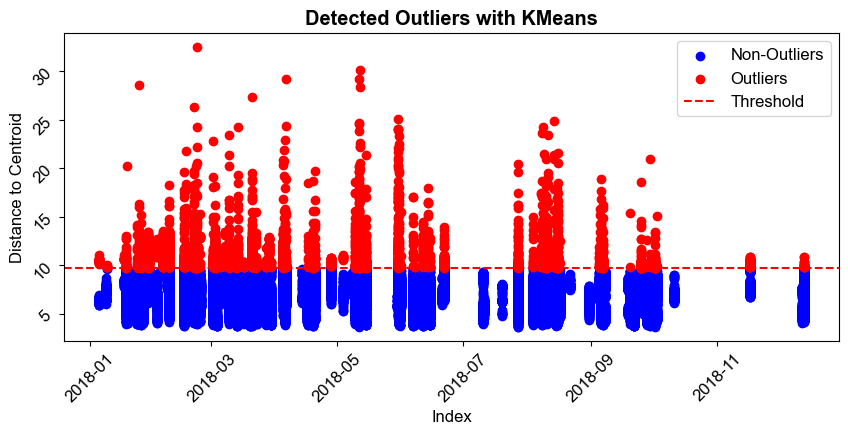

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming X_train_unsupervised_scaled is already defined
n_cluster = 2
kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X_train_unsupervised_scaled)
centroid_distances = kmeans.transform(X_train_unsupervised_scaled)

# Determine the threshold for outliers
threshold = np.percentile(centroid_distances.max(axis=1), 95)
outliers = centroid_distances.max(axis=1) > threshold
num_outliers = np.sum(outliers)

print(f"Number of outliers detected: {num_outliers}")

# Create scatter plot to include a threshold line and highlight outliers
plt.figure(figsize=(10,4))

# Indices for non-outliers and outliers
non_outliers_indices = ~outliers
outliers_indices = outliers

# Plot non-outliers in blue
plt.scatter(X_train_unsupervised_scaled.index[non_outliers_indices], centroid_distances.max(axis=1)[non_outliers_indices], 
            c='blue', label='Non-Outliers')

# Overlay outliers in red
plt.scatter(X_train_unsupervised_scaled.index[outliers_indices], centroid_distances.max(axis=1)[outliers_indices], 
            c='red', label='Outliers')

# Add threshold line
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

plt.xlabel('Index')
plt.ylabel('Distance to Centroid')
plt.title('Detected Outliers with KMeans', fontweight='bold')
plt.legend()
plt.tick_params(labelrotation=45)
plt.show()

#store outliers in outlier_kmeans
outliers_kmeans = pd.Series(outliers, index=X_train_unsupervised_scaled.index)


# Mahalanobis

c:\Users\ggugaratshan\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-101.032921271644881 > -117.817797715887053). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\ggugaratshan\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-104.495533949526305 > -106.121946382203035). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\ggugaratshan\AppData\Local\anaconda3\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-100.251834381846010 > -101.786899022074493). You may want to try with a higher value

Number of outliers detected: 6141


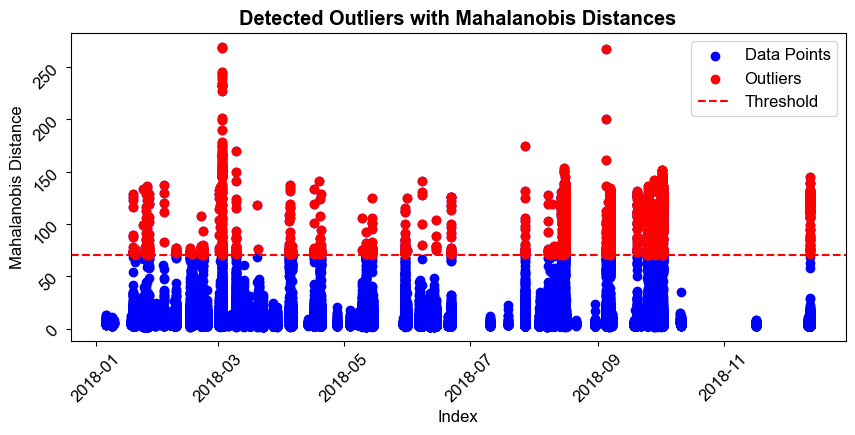

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

def detect_outliers_with_mahalanobis(df):
    # Fit Minimum Covariance Determinant (MCD) estimator
    mcd_estimator = MinCovDet(random_state=42)  # Adding a random state for reproducibility
    mcd_estimator.fit(df)

    # Calculate Mahalanobis Distances
    mahalanobis_distances = mcd_estimator.mahalanobis(df) ** 0.5  # Square root to get distance
    
    # Identify outliers based on Mahalanobis distances
    threshold = np.percentile(mahalanobis_distances, 95)
    outliers = mahalanobis_distances > threshold

    # Evaluate performance
    num_outliers = np.sum(outliers)
   
    print("Number of outliers detected:", num_outliers)
       
    return mahalanobis_distances, outliers, num_outliers, threshold

# Assuming X_train_unsupervised_scaled is defined
mahalanobis_function = detect_outliers_with_mahalanobis(X_train_unsupervised_scaled)

# Unpack results
mahalanobis_distances, outliers_mahalanobis, num_outliers_mahalanobis, threshold_mahalanobis = mahalanobis_function

# Create scatter plot to include a threshold line and highlight outliers
plt.figure(figsize=(10, 4))
# Plot all points
plt.scatter(X_train_unsupervised_scaled.index, mahalanobis_distances, 
            c='blue', label='Data Points')
# Overlay outliers in red
plt.scatter(X_train_unsupervised_scaled.index[outliers_mahalanobis], mahalanobis_distances[outliers_mahalanobis], 
            c='red', label='Outliers')

# Add threshold line
plt.axhline(y=threshold_mahalanobis, color='r', linestyle='--', label='Threshold')

plt.xlabel('Index')
plt.ylabel("Mahalanobis Distance")
plt.title('Detected Outliers with Mahalanobis Distances', fontweight='bold')
plt.legend()
plt.tick_params(labelrotation=45)
plt.show()

#store the outliers in mahalanobis
outliers_mahalanobis = pd.Series(outliers_mahalanobis, index=X_train_unsupervised_scaled.index)


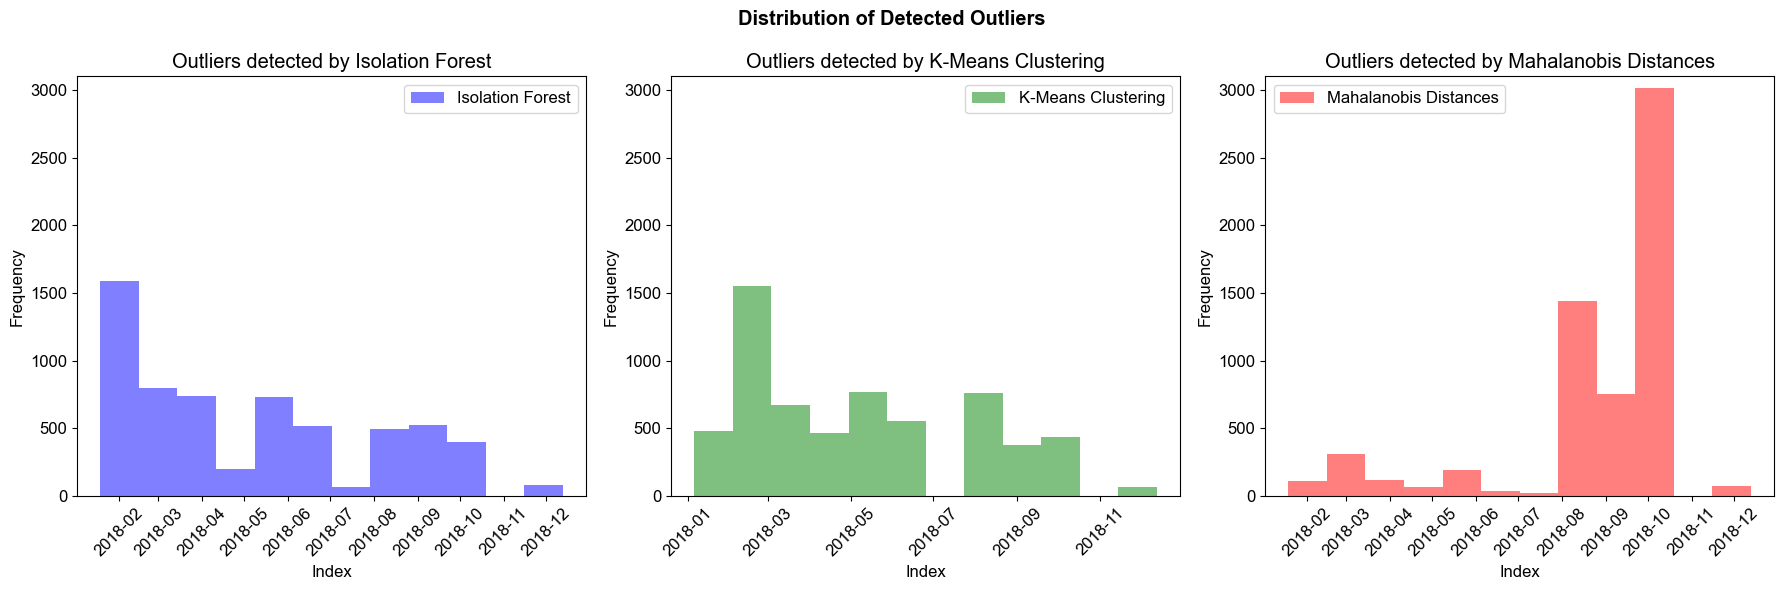

In [102]:

import matplotlib.pyplot as plt


plt.figure(figsize=(18, 6))

# Isolation Forest Outliers
plt.subplot(1, 3, 1)
plt.hist(X_train_unsupervised_scaled.index[outliers_isolation_forest], bins=12, alpha=0.5, label='Isolation Forest', color='b')
plt.title('Outliers detected by Isolation Forest')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
#all y-limit to be the same
plt.ylim(0, 3100)
plt.legend()



# K-Means Clustering Outliers
plt.subplot(1, 3, 2)
plt.hist(X_train_unsupervised_scaled.index[outliers_kmeans], bins=12, alpha=0.5, label='K-Means Clustering', color='g')
plt.title('Outliers detected by K-Means Clustering')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.ylim(0, 3100)
plt.legend()

# Mahalanobis Distance Outliers
plt.subplot(1, 3, 3)
plt.hist(X_train_unsupervised_scaled.index[outliers_mahalanobis], bins=12, alpha=0.5, label='Mahalanobis Distances', color='r')
plt.title('Outliers detected by Mahalanobis Distances')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.ylim(0, 3100)
plt.legend()

plt.suptitle('Distribution of Detected Outliers', fontweight='bold')
plt.tight_layout()


plt.show()


This shows the histograms for each method showing the distribution of the detected outliers. While Isolation Forest and KMeans have relatively similar distributions, the Mahalanobis distances histogram shows a distinct spike, suggesting a concentration of outliers closer to October 2018, when the injector failure occurred.  This observation suggests that the Mahalanobis distance was particularly sensitive to the deviations associated with the failure.  Isolation Forest and Kmeans methods showed a more uniform distribution of outliers over time. The Isolation Forest's performance is less reliant on the assumption of any particular distribution.

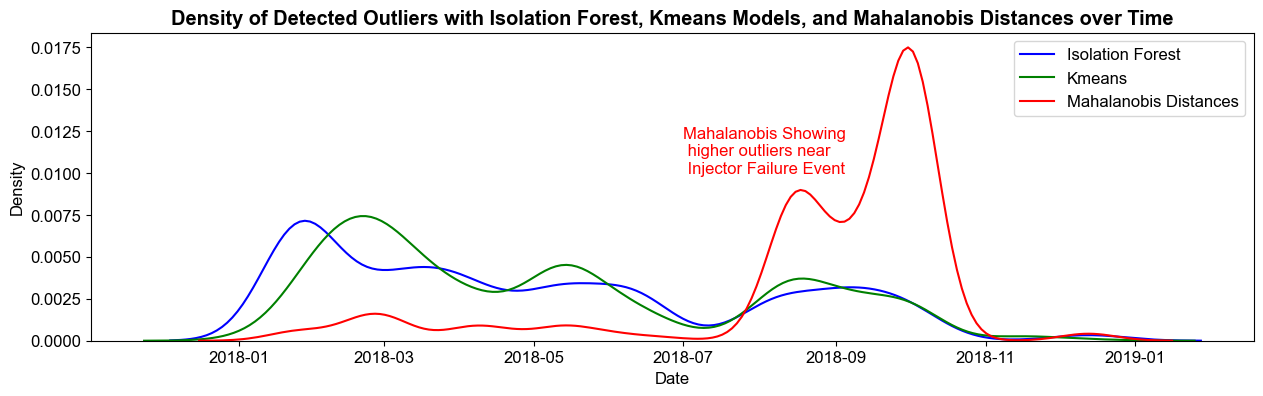

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates
import pandas as pd

# Assuming X_train_unsupervised_scaled is a DataFrame with a DateTimeIndex,
# and outliers_isolation_forest, outlier_kmeans, and outliers_mahalanobis are defined correctly.

# Convert DatetimeIndex to numeric format for KDE plots
dates_numeric = matplotlib.dates.date2num(X_train_unsupervised_scaled.index.to_pydatetime())

plt.figure(figsize=(15, 4))

# Isolation Forest
sns.kdeplot(dates_numeric[outliers_isolation_forest], color='blue', label='Isolation Forest')

# K-Means Clustering
sns.kdeplot(dates_numeric[outliers_kmeans], color='green', label='Kmeans')

# Mahalanobis Distance
sns.kdeplot(dates_numeric[outliers_mahalanobis], color='red', label='Mahalanobis Distances')

plt.xlabel('Date')
plt.ylabel('Density')
plt.title('Density of Detected Outliers with Isolation Forest, Kmeans Models, and Mahalanobis Distances over Time', fontweight='bold')
plt.rc('font', family='Arial', size=12)
plt.legend()

# Add a note to the plot
date_for_annotation = matplotlib.dates.date2num(pd.to_datetime('2018-07-01'))  # Convert the date for annotation
plt.text(date_for_annotation, 0.010, 'Mahalanobis Showing \n higher outliers near \n Injector Failure Event', color='r')

# Adjust x-axis to show dates
plt.gca().xaxis.set_major_locator(matplotlib.dates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))

plt.show()


 This shows the histograms like the previous plots.  Same details.  

 It is generally more scalable but may not capture the correlations between variables as effectively as the Mahalanobis distance. KMeans clustering is sensitive to the number of clusters and the shape of the clusters; hence, it might not always detect outliers effectively in time-series data where the patterns evolve.  The Mahalanobis distance method's effectiveness can be attributed to its ability to measure the distance of a point from the mean of a distribution, considering the correlations between variables. This is particularly important in a multivariate setting where anomalies may not be apparent in the individual variables but are evident when considering the complete feature space. The spike in the Mahalanobis distance density near the failure event indicates that anomalies likely related to the injector failure conditions were detected, thus providing an early warning signal. 

In [4]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.covariance import EmpiricalCovariance

# data is in df_2018_unsupervised_scaled 

# Calculate the Mahalanobis distance for each point in the dataset
def calculate_mahalanobis(X, mean_vector, inv_cov_matrix):
    distances = []
    for i in range(len(X)):
        distance = mahalanobis(X.iloc[i], mean_vector, inv_cov_matrix)
        distances.append(distance)
    return distances

# Function to perform feature ablation and evaluate the impact
def feature_ablation_study(df):
    results = {}
    original_features = df.columns
    # Compute the covariance matrix and its inverse from the full dataset
    cov_matrix = EmpiricalCovariance().fit(df)
    inv_cov_matrix = np.linalg.inv(cov_matrix.covariance_)
    mean_vector = df.mean().values
    original_distances = calculate_mahalanobis(df, mean_vector, inv_cov_matrix)
    original_score = np.mean(original_distances)
    
    for feature in original_features:
        temp_df = df.drop(columns=[feature])
        # Recompute mean vector and covariance matrix without the feature
        cov_matrix = EmpiricalCovariance().fit(temp_df)
        inv_cov_matrix = np.linalg.inv(cov_matrix.covariance_)
        mean_vector = temp_df.mean().values
        distances = calculate_mahalanobis(temp_df, mean_vector, inv_cov_matrix)
        score = np.mean(distances)
        results[feature] = abs(score - original_score)
    
    return results

# Perform the feature ablation study
importance_results = feature_ablation_study(df_2018_unsupervised_scaled)
importance_results_sorted = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)

# Print the importance of features based on the change in Mahalanobis distance
for feature, importance in importance_results_sorted:
    print(f"Feature: {feature}, Importance: {importance}")


Feature: IntManfTemp, Importance: 0.1486301120168494
Feature: TransOilTemp, Importance: 0.1437974846856922
Feature: InjCtlPres, Importance: 0.12915767684469426
Feature: EngOilPres, Importance: 0.12206709050550213
Feature: EngCoolantTemp, Importance: 0.12060687855350194
Feature: BoostPres, Importance: 0.12009570206136644
Feature: InpSftSp, Importance: 0.11557588202436131
Feature: FuelRate, Importance: 0.10936231039328881
Feature: EngSpeed, Importance: 0.10878538863071396
Feature: EngPctLdAtCurSpd, Importance: 0.10404409435352235
Feature: EngPctTorq, Importance: 0.09958258757106364
Feature: InstFuelEco, Importance: 0.0935834362643937
Feature: EngDesiredOpSpd, Importance: 0.08824516265310534
Feature: AccelPedalPos, Importance: 0.08806213096891868
Feature: TransOptShaftSpeedTrans_1587, Importance: 0.08301156262583742
Feature: VehSpeedEng, Importance: 0.0829360594123778
Feature: PctEngLoad, Importance: 0.002845813514983142
Feature: EngDmdPctTorq, Importance: 0.002845755894696822


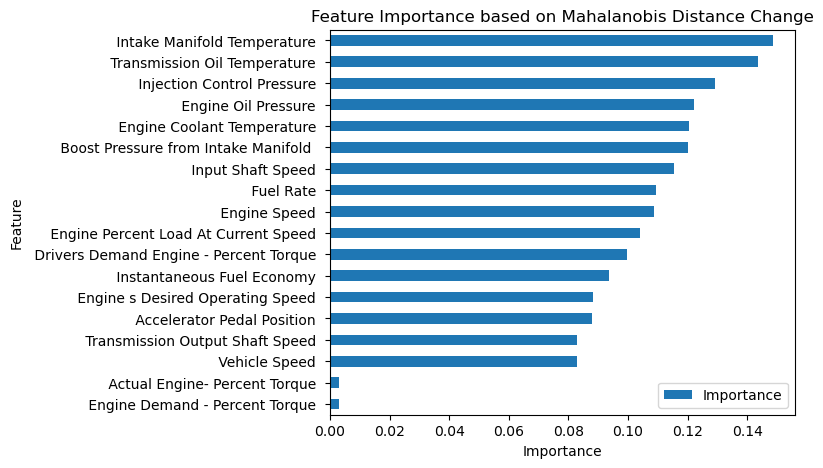

In [43]:

import pandas as pd
import matplotlib.pyplot as plt

importance_results_sorted_channel_name = [df_channel_name_selected_table['channel_name'][df_channel_name_selected_table['Keyword'] == importance_results_sorted[i][0]].values[0] for i in range(len(importance_results_sorted))]
importance_results_sorted_channel_name = [(importance_results_sorted_channel_name[i], importance_results_sorted[i][1]) for i in range(len(importance_results_sorted))]

# Assuming importance_results_sorted is already defined and sorted
importance_df = pd.DataFrame(importance_results_sorted_channel_name, columns=['Feature', 'Importance'])

# Sort the DataFrame by 'Importance' in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Set the index to 'Feature' for plotting
importance_df = importance_df.set_index('Feature')

# Plot the data with a horizontal bar chart
importance_df.plot(kind='barh', figsize=(6, 5))  # Changed to 'barh' for horizontal bar chart

# Set the title and labels
plt.title('Feature Importance based on Mahalanobis Distance Change')
plt.ylabel('Feature')  # Swap xlabel and ylabel
plt.xlabel('Importance')  # Swap xlabel and ylabel

# Invert the y-axis to have the highest value at the top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


[(' Intake Manifold Temperature ', 0.1486301120168494),
 (' Transmission Oil Temperature ', 0.1437974846856922),
 (' Injection Control Pressure ', 0.12915767684469426),
 (' Engine Oil Pressure ', 0.12206709050550213),
 (' Engine Coolant Temperature ', 0.12060687855350194),
 (' Boost Pressure from Intake Manifold  ', 0.12009570206136644),
 (' Input Shaft Speed ', 0.11557588202436131),
 (' Fuel Rate ', 0.10936231039328881),
 (' Engine Speed ', 0.10878538863071396),
 (' Engine Percent Load At Current Speed ', 0.10404409435352235),
 (' Drivers Demand Engine - Percent Torque ', 0.09958258757106364),
 (' Instantaneous Fuel Economy ', 0.0935834362643937),
 (' Engine s Desired Operating Speed ', 0.08824516265310534),
 (' Accelerator Pedal Position ', 0.08806213096891868),
 (' Transmission Output Shaft Speed ', 0.08301156262583742),
 (' Vehicle Speed ', 0.0829360594123778),
 (' Actual Engine- Percent Torque ', 0.002845813514983142),
 (' Engine Demand - Percent Torque ', 0.002845755894696822)]